In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 20191125

@author: zhangji

test the linear relationship
U_t =?= U_sh + U_wm
U_t is the total velocity
U_sh is the velocity induced by shear flow
U_wm is the active velocity. 
"""

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

import os
import glob
import re
import pandas as pd
from scanf import scanf
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pickle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from time import time
from src import support_class as spc
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook

%matplotlib inline
rc('animation', html='html5')
rc('text', usetex=True)
params = {'text.latex.preamble': [r'\usepackage{bm}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)
fontsize = 40
figsize = (30, 16)
PWD = os.getcwd()

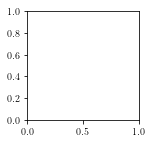

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
fft_pickle = 'hlxB01_tau1a'

In [4]:
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
tw = pickle_data[0][1][4][2].values
tw_fft = np.fft.fft2(tw)
tw_fft[0, 0]

(5073.741266962632-3.45105888310826e-14j)

In [16]:
# do 2D IFFT myself and compare with numpy version
use_idx_max = 6

# ((psi, ((theta, phi, ui))))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta, tphi = pickle_data[0][1][0][:2]
tpsi = np.array([ti[0] for ti in pickle_data])
tw = pickle_data[0][1][5][2].values

tw_fft = np.fft.fft2(tw)
th_freq = np.fft.fftfreq(ttheta.size, 1 / ttheta.size)
ph_freq = np.fft.fftshift(np.fft.fftfreq(tphi.size, 1 / tphi.size))
idx_max = np.dstack(np.unravel_index(np.argsort(np.abs(tw_fft).ravel()), tw_fft.shape))[0][::-1]
    
# numpy version IFFT
idx = np.zeros_like(tw_fft, dtype=bool)
for ti in idx_max[:use_idx_max]:
    idx[ti[0], ti[1]] = 1
tw_fft2 = tw_fft * idx
tw2 = np.fft.ifft2(tw_fft2)

# do IFFT myself
tw3 = np.zeros_like(tw2)
tM, tN = tw_fft.shape
tm, tn = np.meshgrid(np.arange(tM), np.arange(tN), indexing='ij')
for tk, tl in idx_max[:use_idx_max]:
    tAkl = tw_fft[tk, tl]
    tw3 = tw3 + tAkl * np.exp(2 * np.pi * 1j * (tm * tk / tM + tn * tl / tN)) / (tM * tN)
    print(tk, tl, tAkl)
    print((np.abs(tw3.imag) / np.abs(tw3)).max())
print((tw3 - tw).max(), (tw3 - tw2).max())

63 126 (496.91459196578325-30.56270351293764j)
0.9999999358399099
1 1 (496.91459196578325+30.56270351293764j)
1.5812292352666583e-13
63 1 (-493.6282773215614+61.37732137471735j)
0.999999973976085
1 126 (-493.6282773215614-61.37732137471735j)
8.22866242684602e-10
0 1 (24.6832282383372+13.460859769844536j)
0.9999998203364672
0 126 (24.6832282383372-13.460859769844536j)
3.5889675666064704e-11
(0.032211690716427224-1.130606025467884e-15j) (1.7569279364693102e-14+9.676159379800284e-15j)


In [13]:
tM, tN

(64, 127)

In [11]:
# print values of primary frequence
print_idx_max = 20

# ((psi, ((theta, phi, ui))))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta, tphi = pickle_data[0][1][0][:2]
tpsi = np.array([ti[0] for ti in pickle_data])
tw = pickle_data[0][1][3][2].values

tw_fft = np.fft.fft2(tw)
th_freq = np.fft.fftfreq(ttheta.size, 1 / ttheta.size)
ph_freq = np.fft.fftshift(np.fft.fftfreq(tphi.size, 1 / tphi.size))
idx_max = np.dstack(np.unravel_index(np.argsort(np.abs(tw_fft).ravel()), tw_fft.shape))[0][::-1]
for i0, (tk, tl) in enumerate(idx_max[:print_idx_max]):
    if not np.mod(i0, 2):
        print('*', tk, tl, tw_fft[tk, tl])
    else:
        print(' ', tk, tl, tw_fft[tk, tl])

* 0 125 (-10.431976189909129+463.0762014969027j)
  0 2 (-10.431976189909129-463.0762014969027j)
* 63 2 (20.44535688051981+251.23003585227423j)
  1 125 (20.44535688051981-251.23003585227423j)
* 63 125 (-9.791505565124627-230.2216224572743j)
  1 2 (-9.791505565124627+230.2216224572743j)
* 0 4 (-3.5857836187311283+18.33841493908389j)
  0 123 (-3.5857836187311283-18.33841493908389j)
* 63 0 (9.686977584393603+14.00394118148867j)
  1 0 (9.686977584393604-14.00394118148867j)
* 2 125 (-0.8410520970555293+14.586198383492077j)
  62 2 (-0.8410520970555293-14.586198383492077j)
* 62 125 (0.2804958636153597+14.129310152726475j)
  2 2 (0.2804958636153597-14.129310152726475j)
* 0 3 (-0.3217012686972088+9.318240085270249j)
  0 124 (-0.3217012686972088-9.318240085270249j)
* 63 4 (1.0889653532438177-8.630077491943997j)
  1 123 (1.0889653532438177+8.630077491943997j)
* 2 0 (-6.4462300244202915+3.9515055356199547j)
  62 0 (-6.4462300244202915-3.9515055356199547j)


In [26]:
print(tw.shape, tw_fft.shape, ttheta.shape, tphi.shape)

(64, 127) (64, 127) (64,) (127,)


use frequence pairs -10.431976+463.076201i and -10.431976-463.076201i at (0, 125) and (0, 2)
absolute abs of imag part is 5.857966985676993e-17


/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


use frequence pairs 20.445357+251.230036i and 20.445357-251.230036i at (63, 2) and (1, 125)
absolute abs of imag part is 3.87116788007852e-17
use frequence pairs -9.791506-230.221622i and -9.791506+230.221622i at (63, 125) and (1, 2)
absolute abs of imag part is 3.473346847020178e-17
use frequence pairs -10.431976+463.076201i and -10.431976-463.076201i at (0, 125) and (0, 2)
use frequence pairs 20.445357+251.230036i and 20.445357-251.230036i at (63, 2) and (1, 125)
use frequence pairs -9.791506-230.221622i and -9.791506+230.221622i at (63, 125) and (1, 2)
absolute abs of imag part is 1.4030058059443075e-16


True

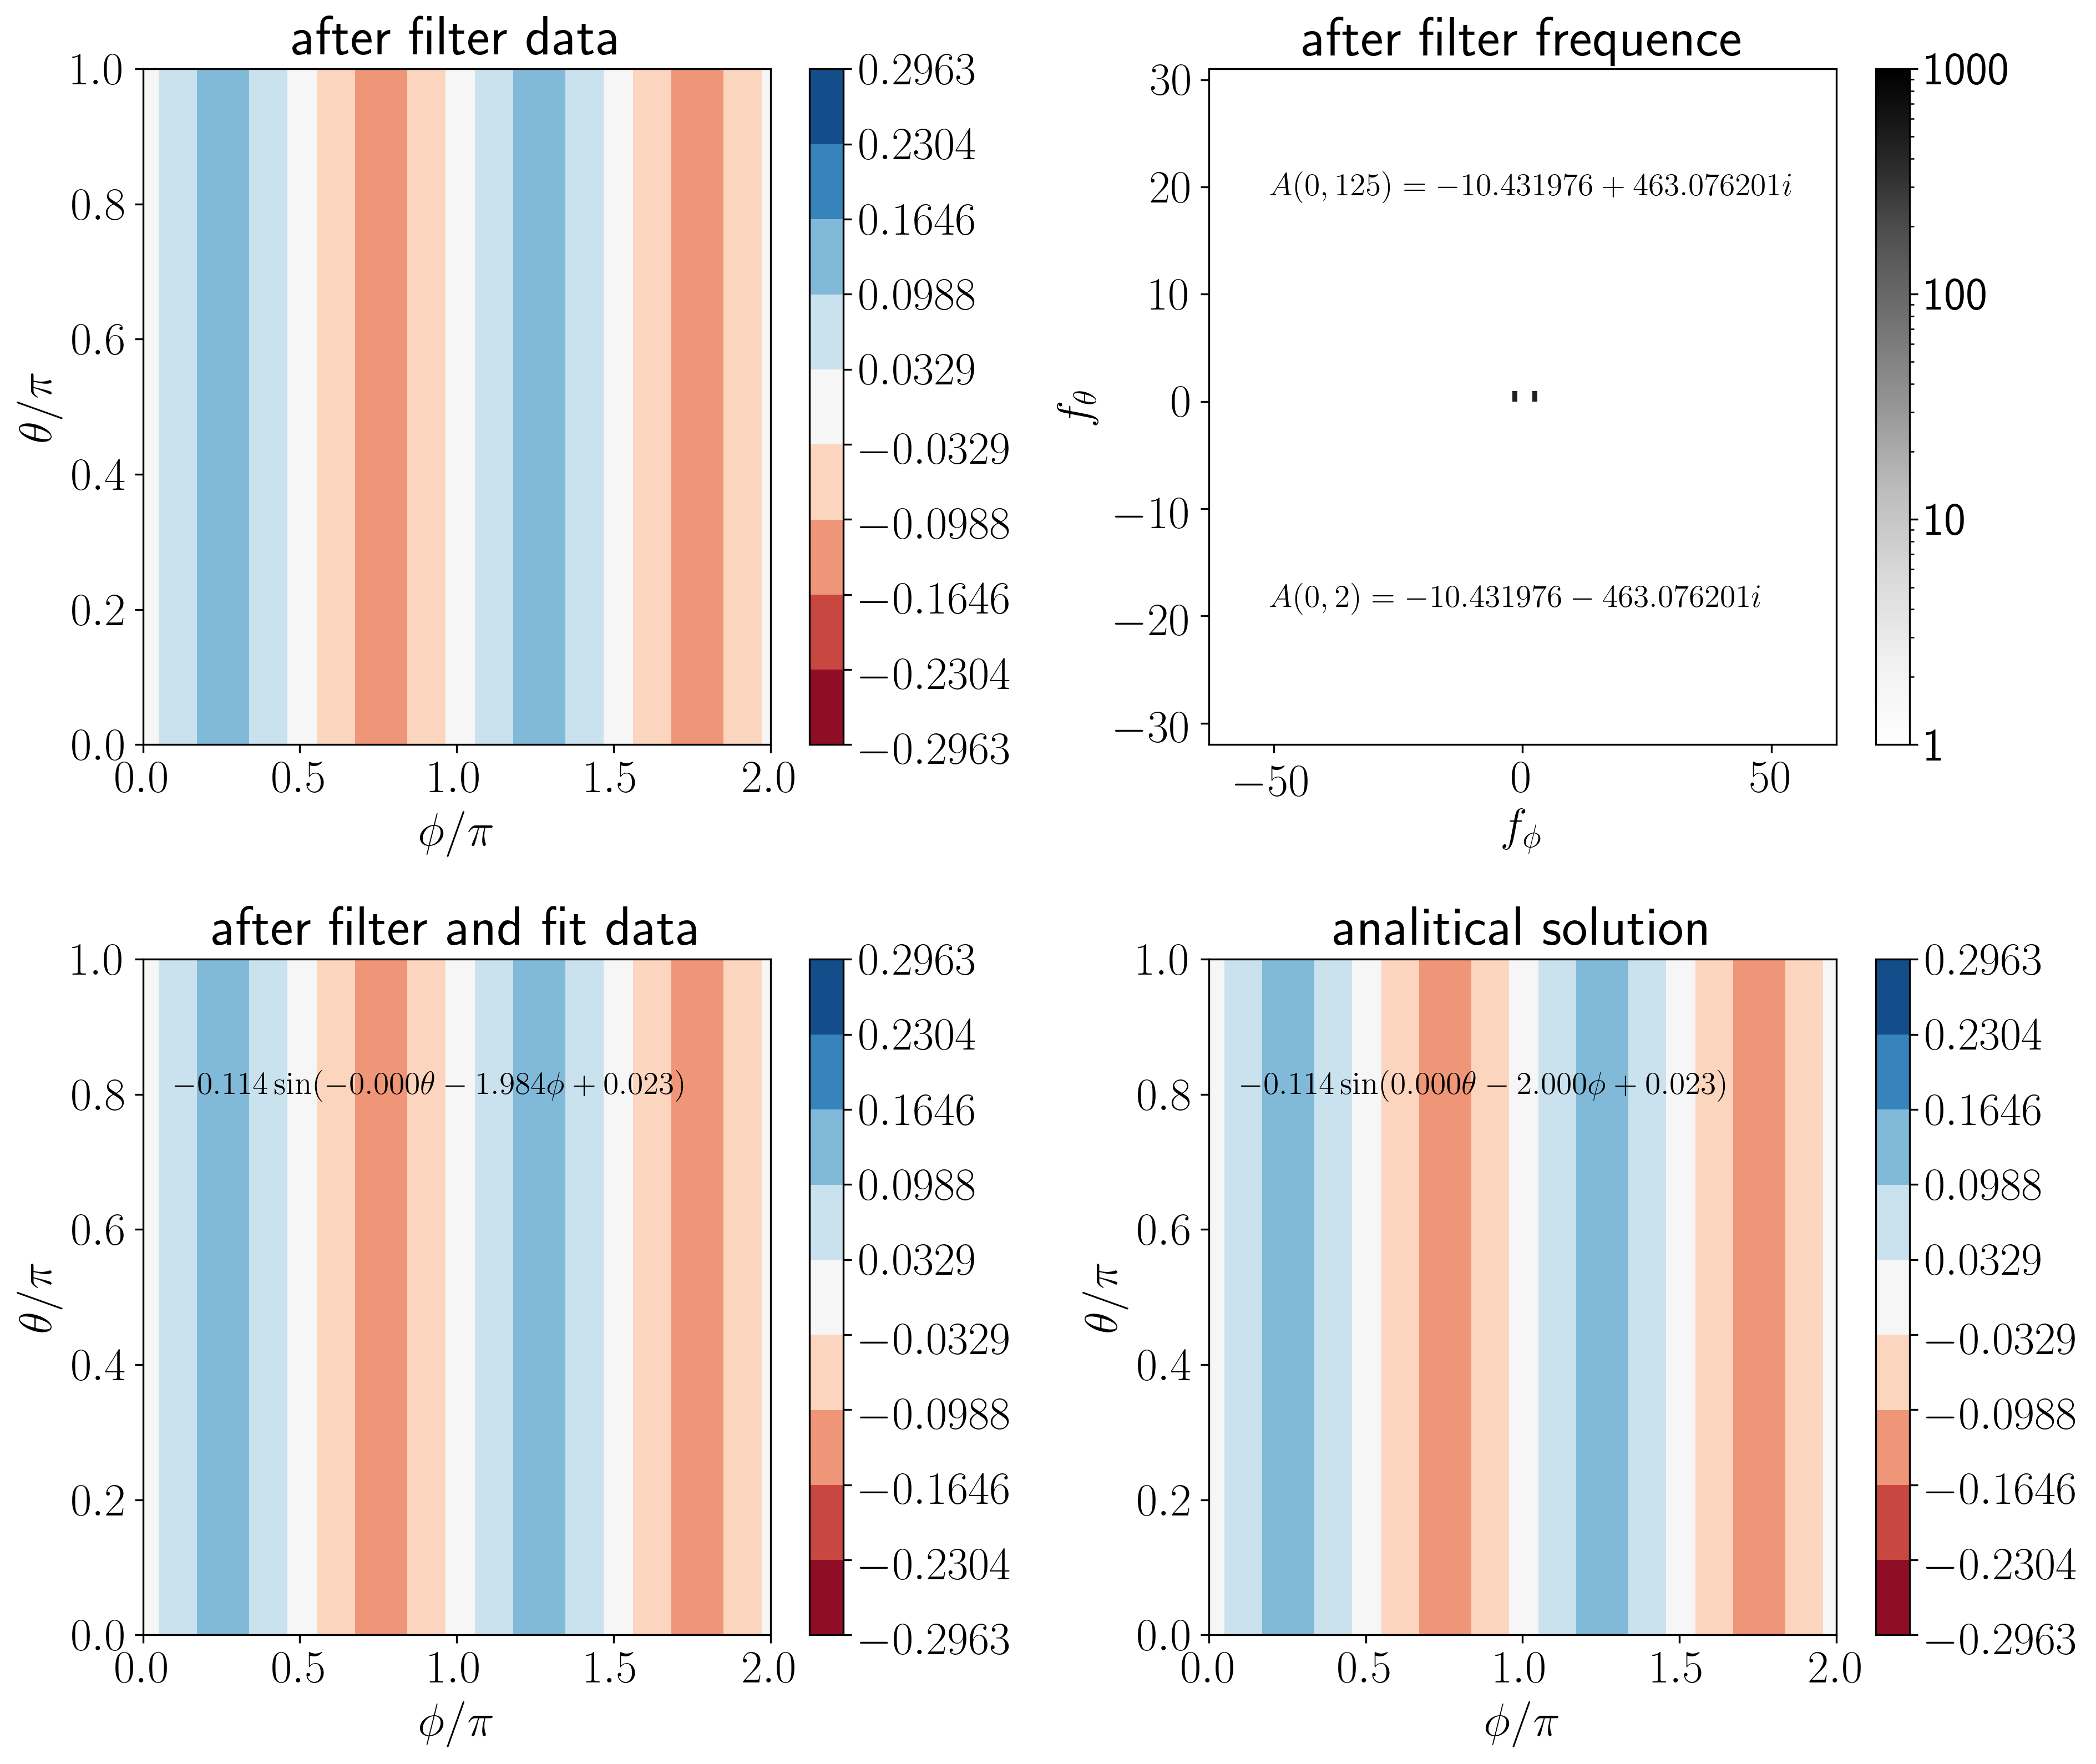

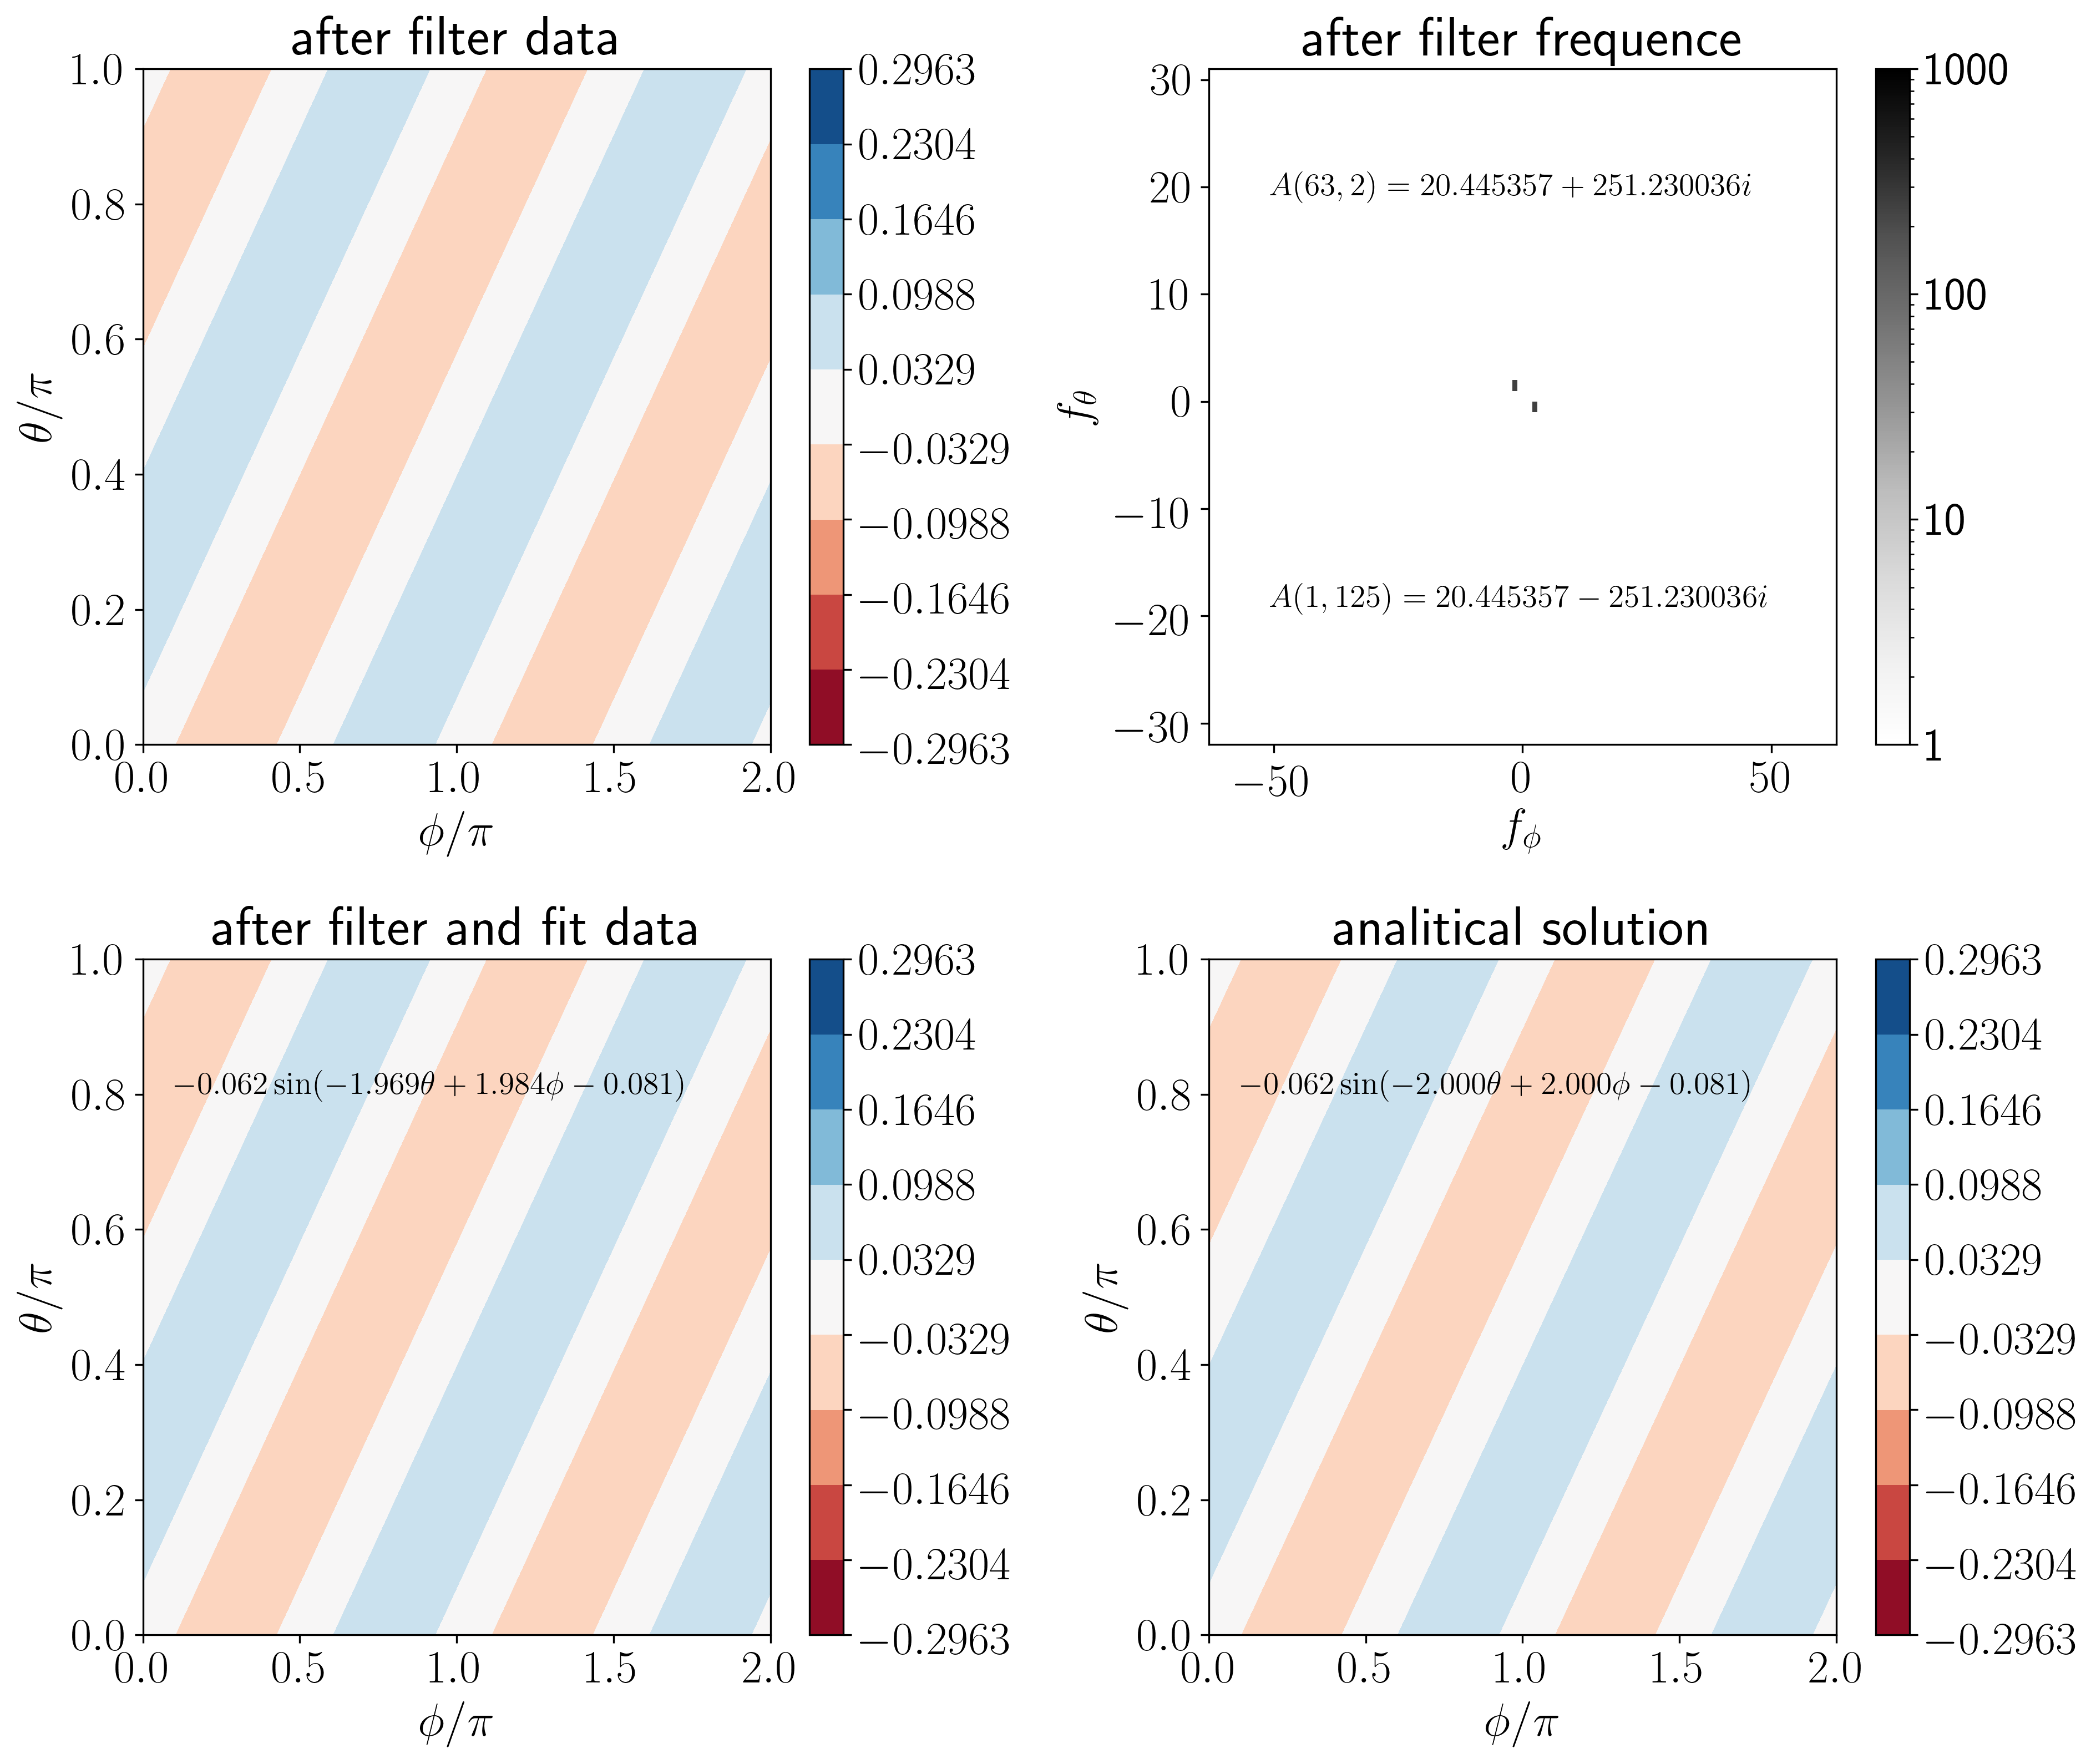

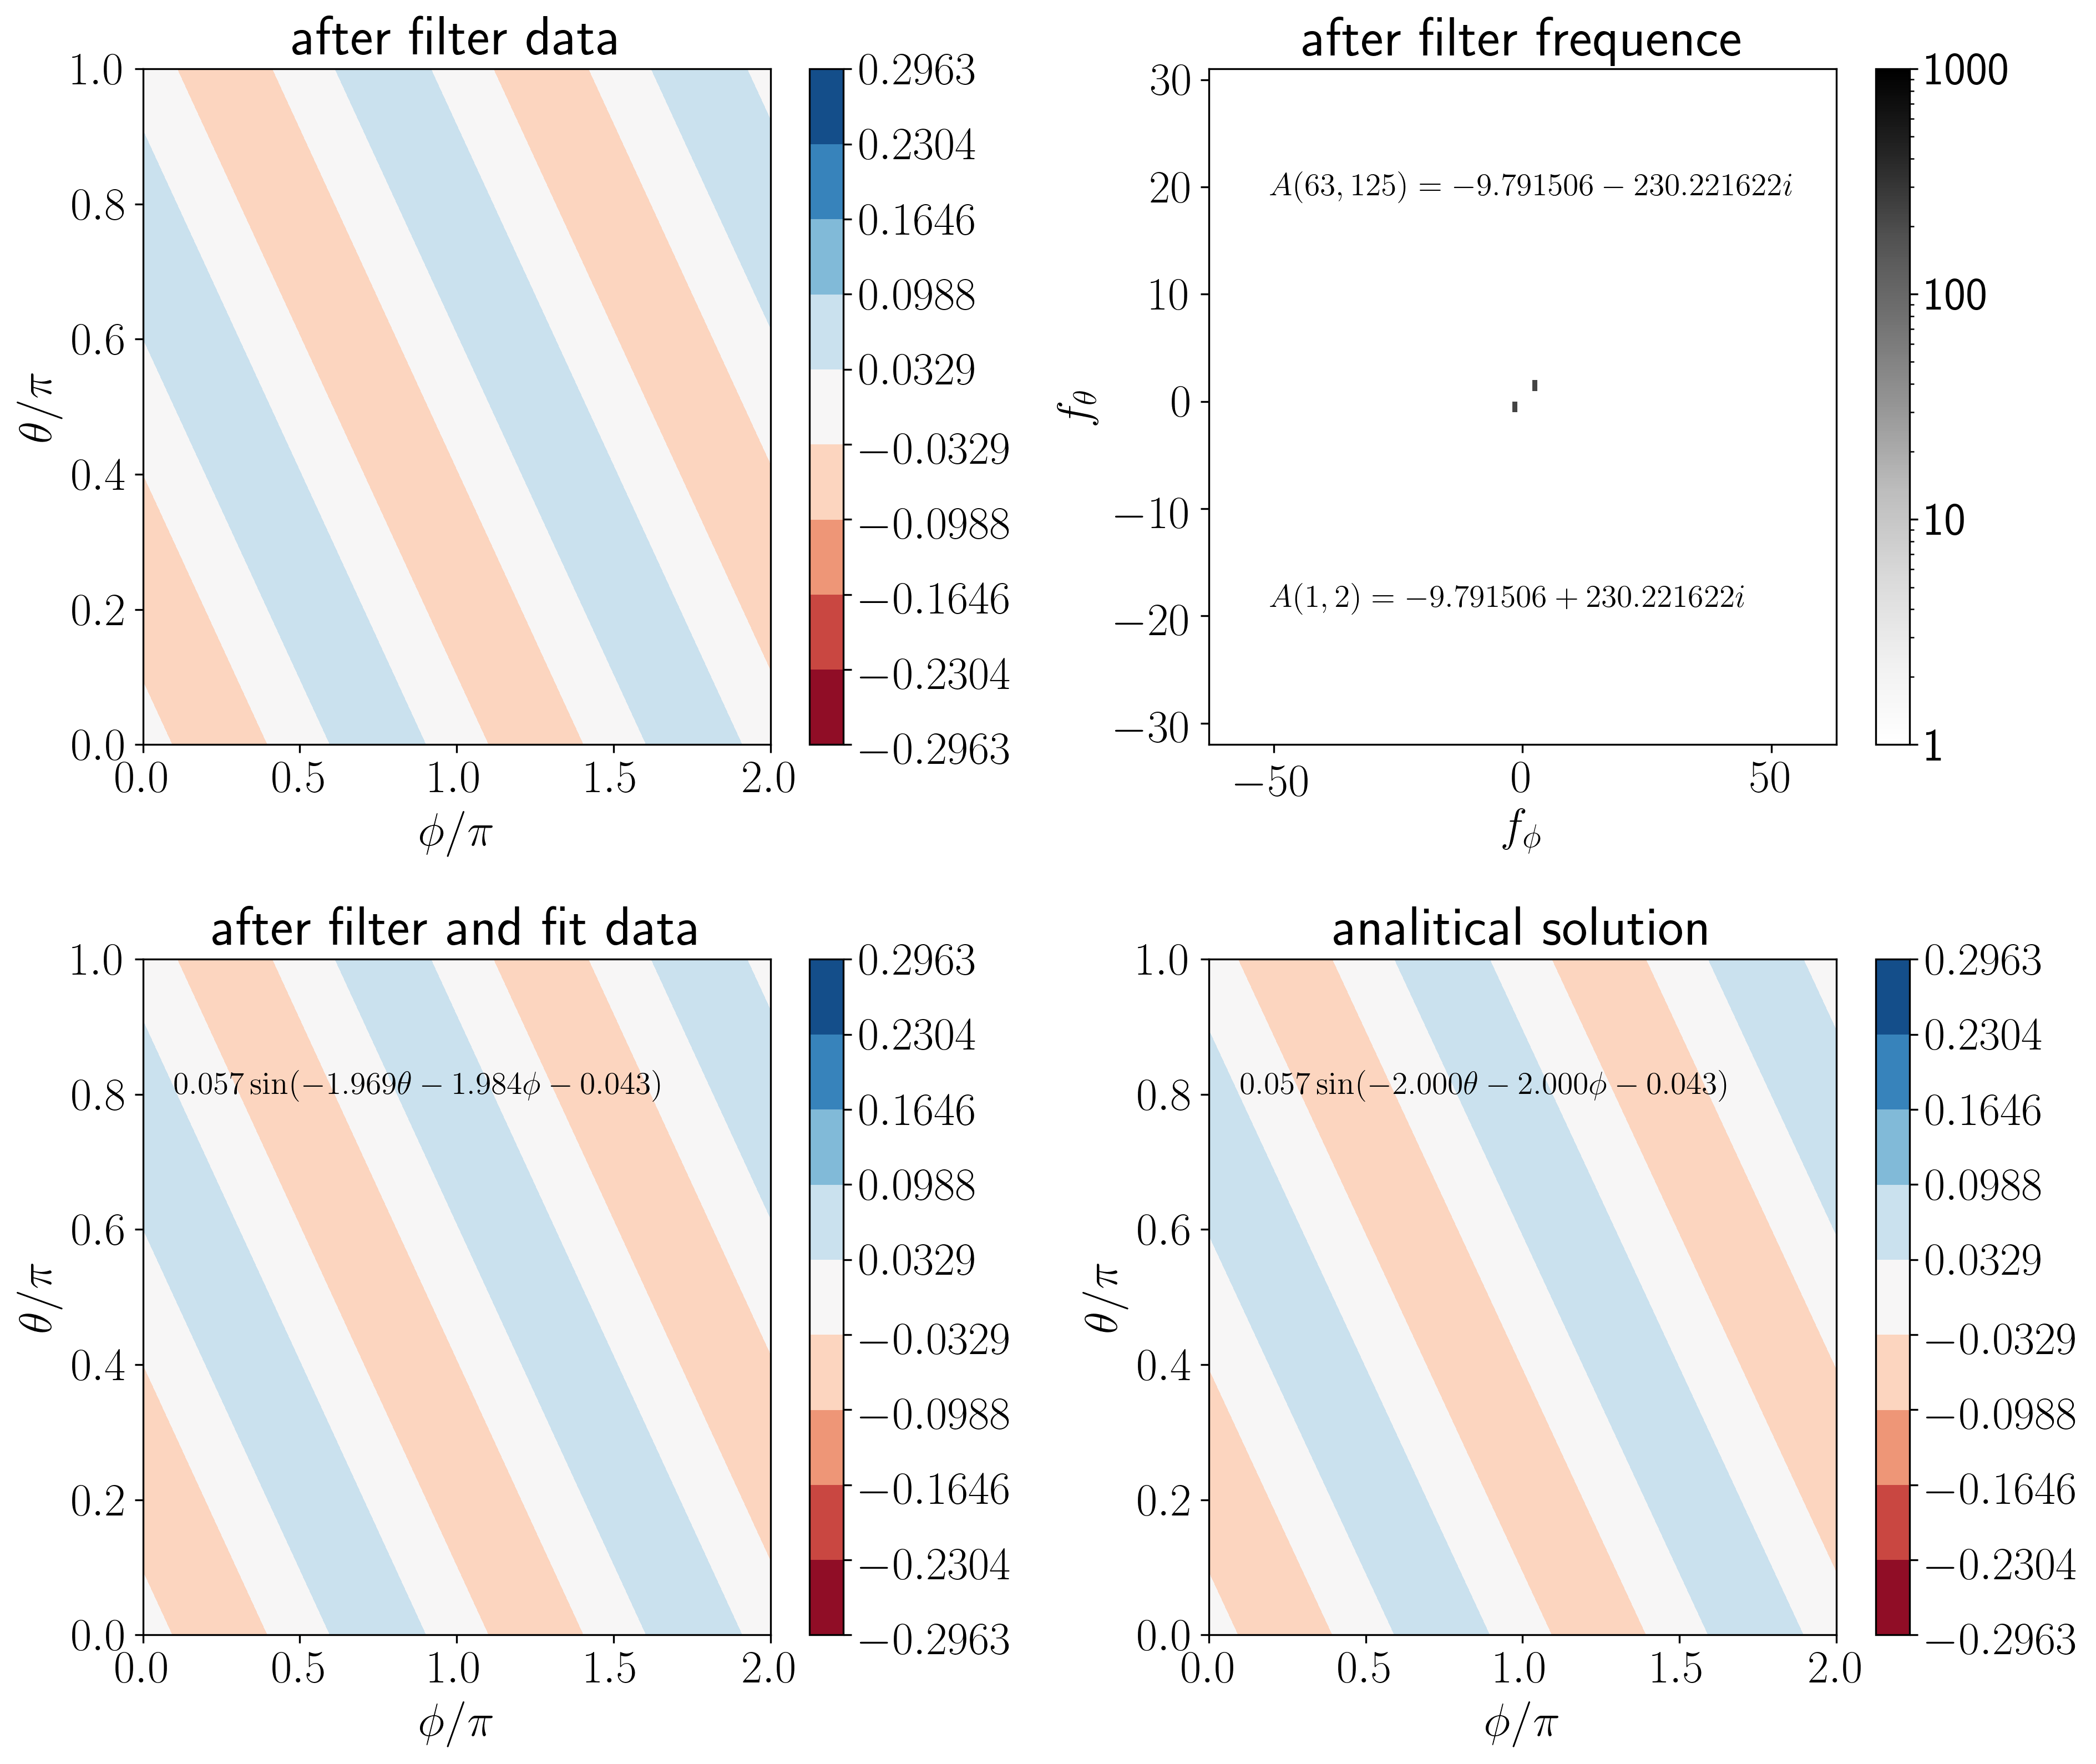

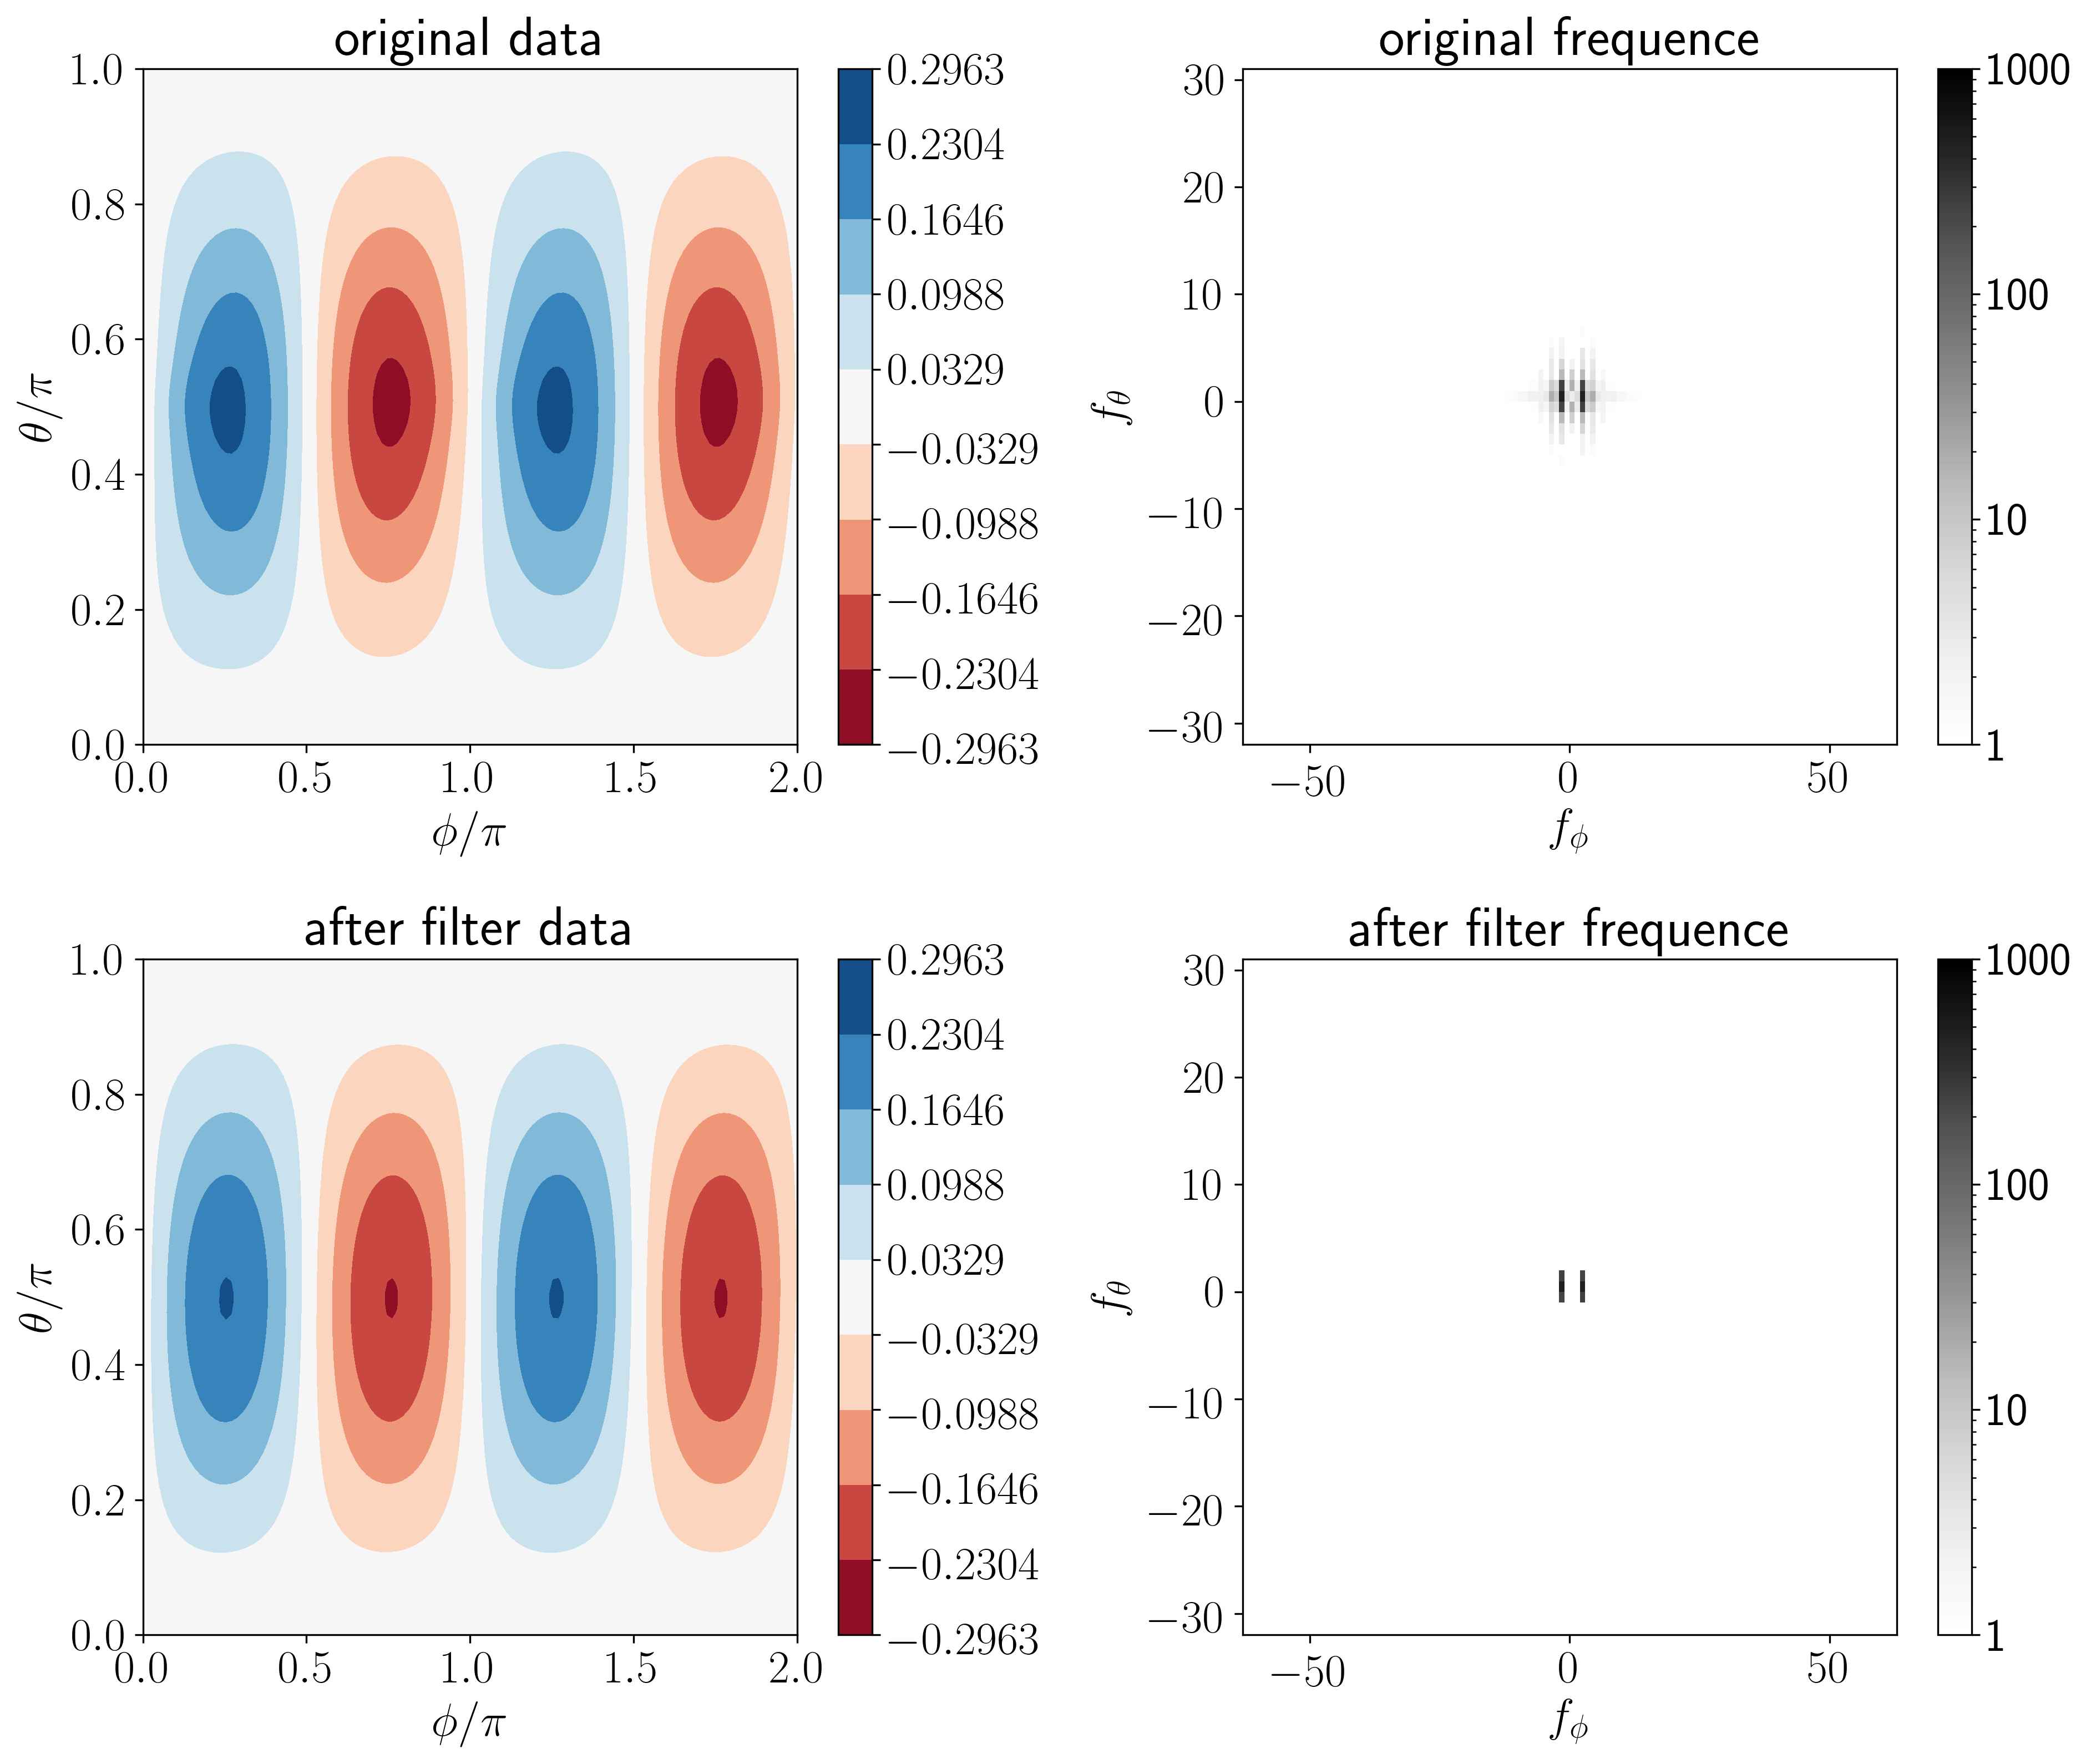

In [23]:
# 2D fft of Wx, Wy, Wz
importlib.reload(spf_tb)
use_uidx = 3 # 3: wx, 4: wy, 5: wz
tktl_list = [[0, 125], [63, 2], [63, 125]]

# ((psi, ((theta, phi, ui))))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta, tphi = pickle_data[0][1][0][:2]
tpsi = np.array([ti[0] for ti in pickle_data])
tw = pickle_data[0][1][use_uidx][2].values

for tktl in tktl_list:
    if np.sum(tktl) < 1:
        spf_tb.show_fft_major(tw, (tktl, ), ttheta, tphi)
    else:
        spf_tb.show_fft_fit(tw, tktl, ttheta, tphi)

spf_tb.show_fft_major(tw, tktl_list, ttheta, tphi)

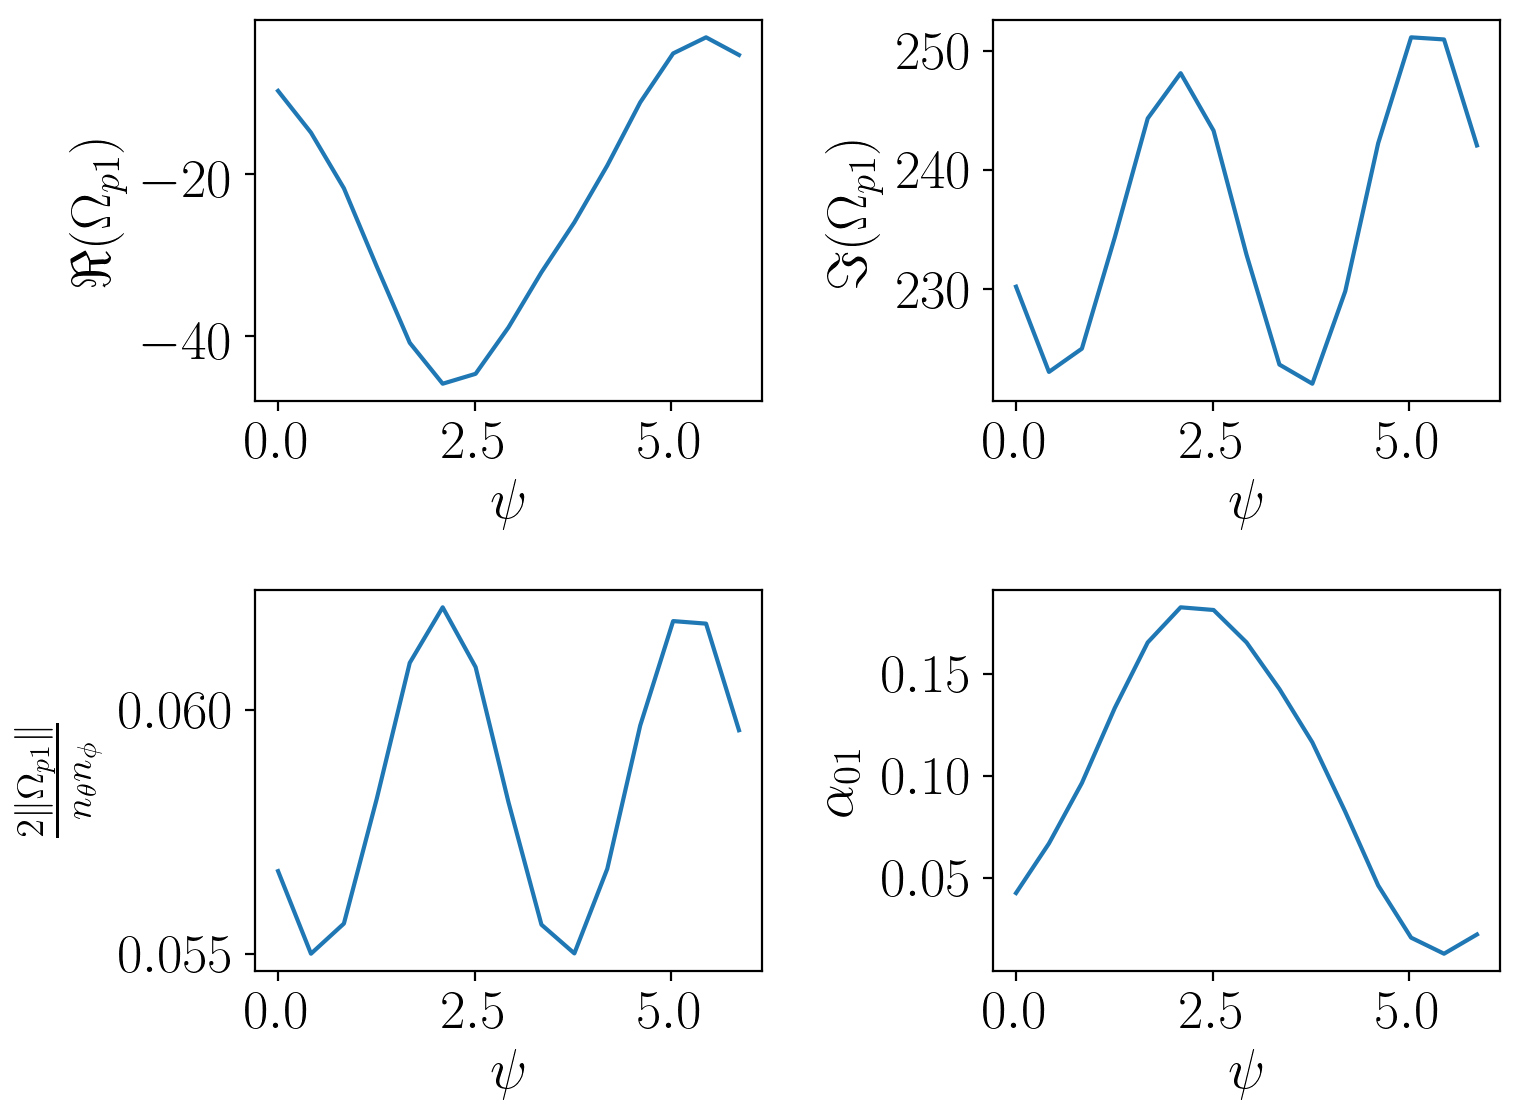

In [76]:
# 2D fft of Wx, Wy, Wz, investigate Amp and \alpha as function of \psi
importlib.reload(spf_tb)
use_uidx = 3 # 3: wx, 4: wy, 5: wz
tktl = [0, 2]
tktl = [63, 2]
tktl = [1, 2]

# ((psi, ((theta, phi, ui))))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta, tphi = pickle_data[0][1][0][:2]
tpsi = np.array([ti[0] for ti in pickle_data])

Akl_list = []
Amp_list = []
alpha_list = []
psi_list = []
for tpsi, table_psi_data in pickle_data[:]:
    psi_list.append(tpsi)
    tw = table_psi_data[use_uidx][2].values
#     spf_tb.show_fft_fit(tw, tktl, ttheta, tphi)
    Akl1, Amp_use, w_th_use, w_ph_use, alpha_use = spf_tb.factor_wpi_kl1(tw, tktl)
    Akl_list.append(Akl1)
    Amp_list.append(Amp_use)
    alpha_list.append(alpha_use)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=200)
fig.patch.set_facecolor('white')
ax = axes[0, 0]
ax.plot(psi_list, np.real(Akl_list))
ax.set_xlabel('$\\psi$')
ax.set_ylabel('$\\Re(\\Omega_{p%d})$' % (use_uidx - 2))
ax = axes[0, 1]
ax.plot(psi_list, np.imag(Akl_list))
ax.set_xlabel('$\\psi$')
ax.set_ylabel('$\\Im(\\Omega_{p%d})$' % (use_uidx - 2))
ax = axes[1, 0]
ax.plot(psi_list, Amp_list)
ax.set_xlabel('$\\psi$')
ax.set_ylabel('$\\frac{2 \\left \\lVert \\Omega_{p%d} \\right \\rVert}{n_\\theta n_\\phi}$' % (use_uidx - 2))
ax = axes[1, 1]
ax.plot(psi_list, alpha_list)
ax.set_xlabel('$\\psi$')
ax.set_ylabel('$\\alpha_{0%d}$' % (use_uidx - 2))
plt.tight_layout()


## Full 3D FFT version

In [105]:
use_uidx = 3 # 3: wx, 4: wy, 5: wz

In [106]:
# do 3D IFFT myself and compare with numpy version
importlib.reload(spf_tb)
use_idx_max = 6

# ((psi, ((theta, phi, ui), )))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta, tphi = pickle_data[0][1][0][:2]
tpsi = np.array([ti[0] for ti in pickle_data])
U_all = [[] for i in range(6)]
for tpsi, table_psi_data in pickle_data:
    for (ty, tx, tU), Ui in zip(table_psi_data, U_all):
        Ui.append((tpsi, ty, tx, tU))
tw = np.dstack([tU.values for _, _, _, tU in U_all[use_uidx]])

tw_fft = np.fft.fftn(tw)
idx_max = np.dstack(np.unravel_index(np.argsort(np.abs(tw_fft).ravel()), tw_fft.shape))[0][::-1]
# numpy version IFFT
idx = np.zeros_like(tw_fft, dtype=bool)
for ti in idx_max[:use_idx_max]:
    idx[ti[0], ti[1], ti[2]] = 1
tw_fft2 = tw_fft * idx
tw2 = np.fft.ifftn(tw_fft2)

print()
# do IFFT myself
tw3 = np.zeros_like(tw2)
tM, tN, tO = tw_fft.shape
tm, tn, to = np.meshgrid(np.arange(tM), np.arange(tN), np.arange(tO), indexing='ij')
for tk, tl, tj in idx_max[:use_idx_max]:
    tAkl = tw_fft[tk, tl, tj]
    tw3 = tw3 + tAkl * np.exp(2 * np.pi * 1j * tm * tk / tM) / tM * \
                       np.exp(2 * np.pi * 1j * tn * tl / tN) / tN * \
                       np.exp(2 * np.pi * 1j * to * tj / tO) / tO
    print(tk, tl, tj, tAkl)
    print((np.abs(tw3.imag) / np.abs(tw3)).max())
print(np.abs(tw3 - tw2).max())


0 2 0 (334.02765451165243-6746.025480742161j)
0.9999999999999085
0 125 0 (334.02765451165203+6746.025480742161j)
8.032988099633599e-14
63 125 0 (-350.38469166543416-3543.4488780540723j)
0.9999997356656901
1 2 0 (-350.38469166543445+3543.4488780540723j)
8.635885642168899e-12
63 2 0 (-1.3793505472179866+3560.674128435263j)
0.9999976244549587
1 125 0 (-1.3793505472178167-3560.6741284352624j)
4.919743273245861e-09
1.8080292616476485e-14


In [107]:
# print values of primary frequence
importlib.reload(spf_tb)
print_idx_max = 100

# ((psi, ((theta, phi, ui), )))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta, tphi = pickle_data[0][1][0][:2]
tpsi = np.array([ti[0] for ti in pickle_data])
U_all = [[] for i in range(6)]
for tpsi, table_psi_data in pickle_data:
    for (ty, tx, tU), Ui in zip(table_psi_data, U_all):
        Ui.append((tpsi, ty, tx, tU))
tw = np.dstack([tU.values for _, _, _, tU in U_all[use_uidx]])

tw_fft = np.fft.fftn(tw)
idx_max = np.dstack(np.unravel_index(np.argsort(np.abs(tw_fft).ravel()), tw_fft.shape))[0][::-1]
t1 = []
for i0, (tk, tl, tj) in enumerate(idx_max[:print_idx_max]):
    t1.append(np.abs(tw_fft[tk, tl, tj]))
    if not np.mod(i0, 2):
        print('%5d * [%d, %d, %d] ' % (i0, tk, tl, tj), tw_fft[tk, tl, tj], np.abs(tw_fft[tk, tl, tj]))
    else:
        print('        [%d, %d, %d] ' % (tk, tl, tj), tw_fft[tk, tl, tj], np.abs(tw_fft[tk, tl, tj]))


    0 * [0, 2, 0]  (334.02765451165243-6746.025480742161j) 6754.290063419031
        [0, 125, 0]  (334.02765451165203+6746.025480742161j) 6754.290063419031
    2 * [63, 125, 0]  (-350.38469166543416-3543.4488780540723j) 3560.7301756151287
        [1, 2, 0]  (-350.38469166543445+3543.4488780540723j) 3560.7301756151287
    4 * [63, 2, 0]  (-1.3793505472179866+3560.674128435263j) 3560.6743956048763
        [1, 125, 0]  (-1.3793505472178167-3560.6741284352624j) 3560.674395604876
    6 * [0, 2, 1]  (-242.83450218760288-175.73717608105125j) 299.7534828982698
        [0, 125, 14]  (-242.83450218760288+175.73717608105125j) 299.7534828982698
    8 * [0, 2, 14]  (-259.00284326569215+150.88880933953976j) 299.74973828782015
        [0, 125, 1]  (-259.00284326569215-150.88880933953976j) 299.74973828782015
   10 * [0, 123, 0]  (-25.598476488068542-257.8690594063649j) 259.1365157549849
        [0, 4, 0]  (-25.598476488068492+257.86905940636484j) 259.1365157549848
   12 * [62, 125, 0]  (32.30385825708

In [108]:
tktltj_list = ([0, 2, 0], [63, 125, 0], [63, 2, 0], ) # wx
# tktltj_list = ([0, 0, 0], [63, 0, 0], [0, 125, 0], [63, 125, 0], [63, 2, 0]) # wy
# tktltj_list = ([63, 126, 0], [63, 1, 0], [0, 125, 0], [63, 125, 0], [63, 2, 0]) # wz


(-1, 50)

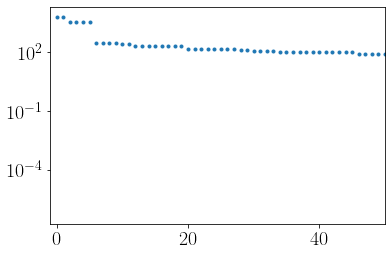

In [110]:
t1 = [np.abs(tw_fft[tk, tl, tj]) for tk, tl, tj in idx_max]
plt.semilogy(t1, '.')
plt.xlim(-1, 50)
# plt.ylim(10, 100)

use frequence pairs 7589.076647-561.280553i and 7589.076647+561.280553i at (63, 126, 0) and (1, 1, 0)
use frequence pairs -7607.538225+185.285116i and -7607.538225-185.285116i at (63, 1, 0) and (1, 126, 0)
absolute abs of imag part is 1.0934726017123111e-16


True

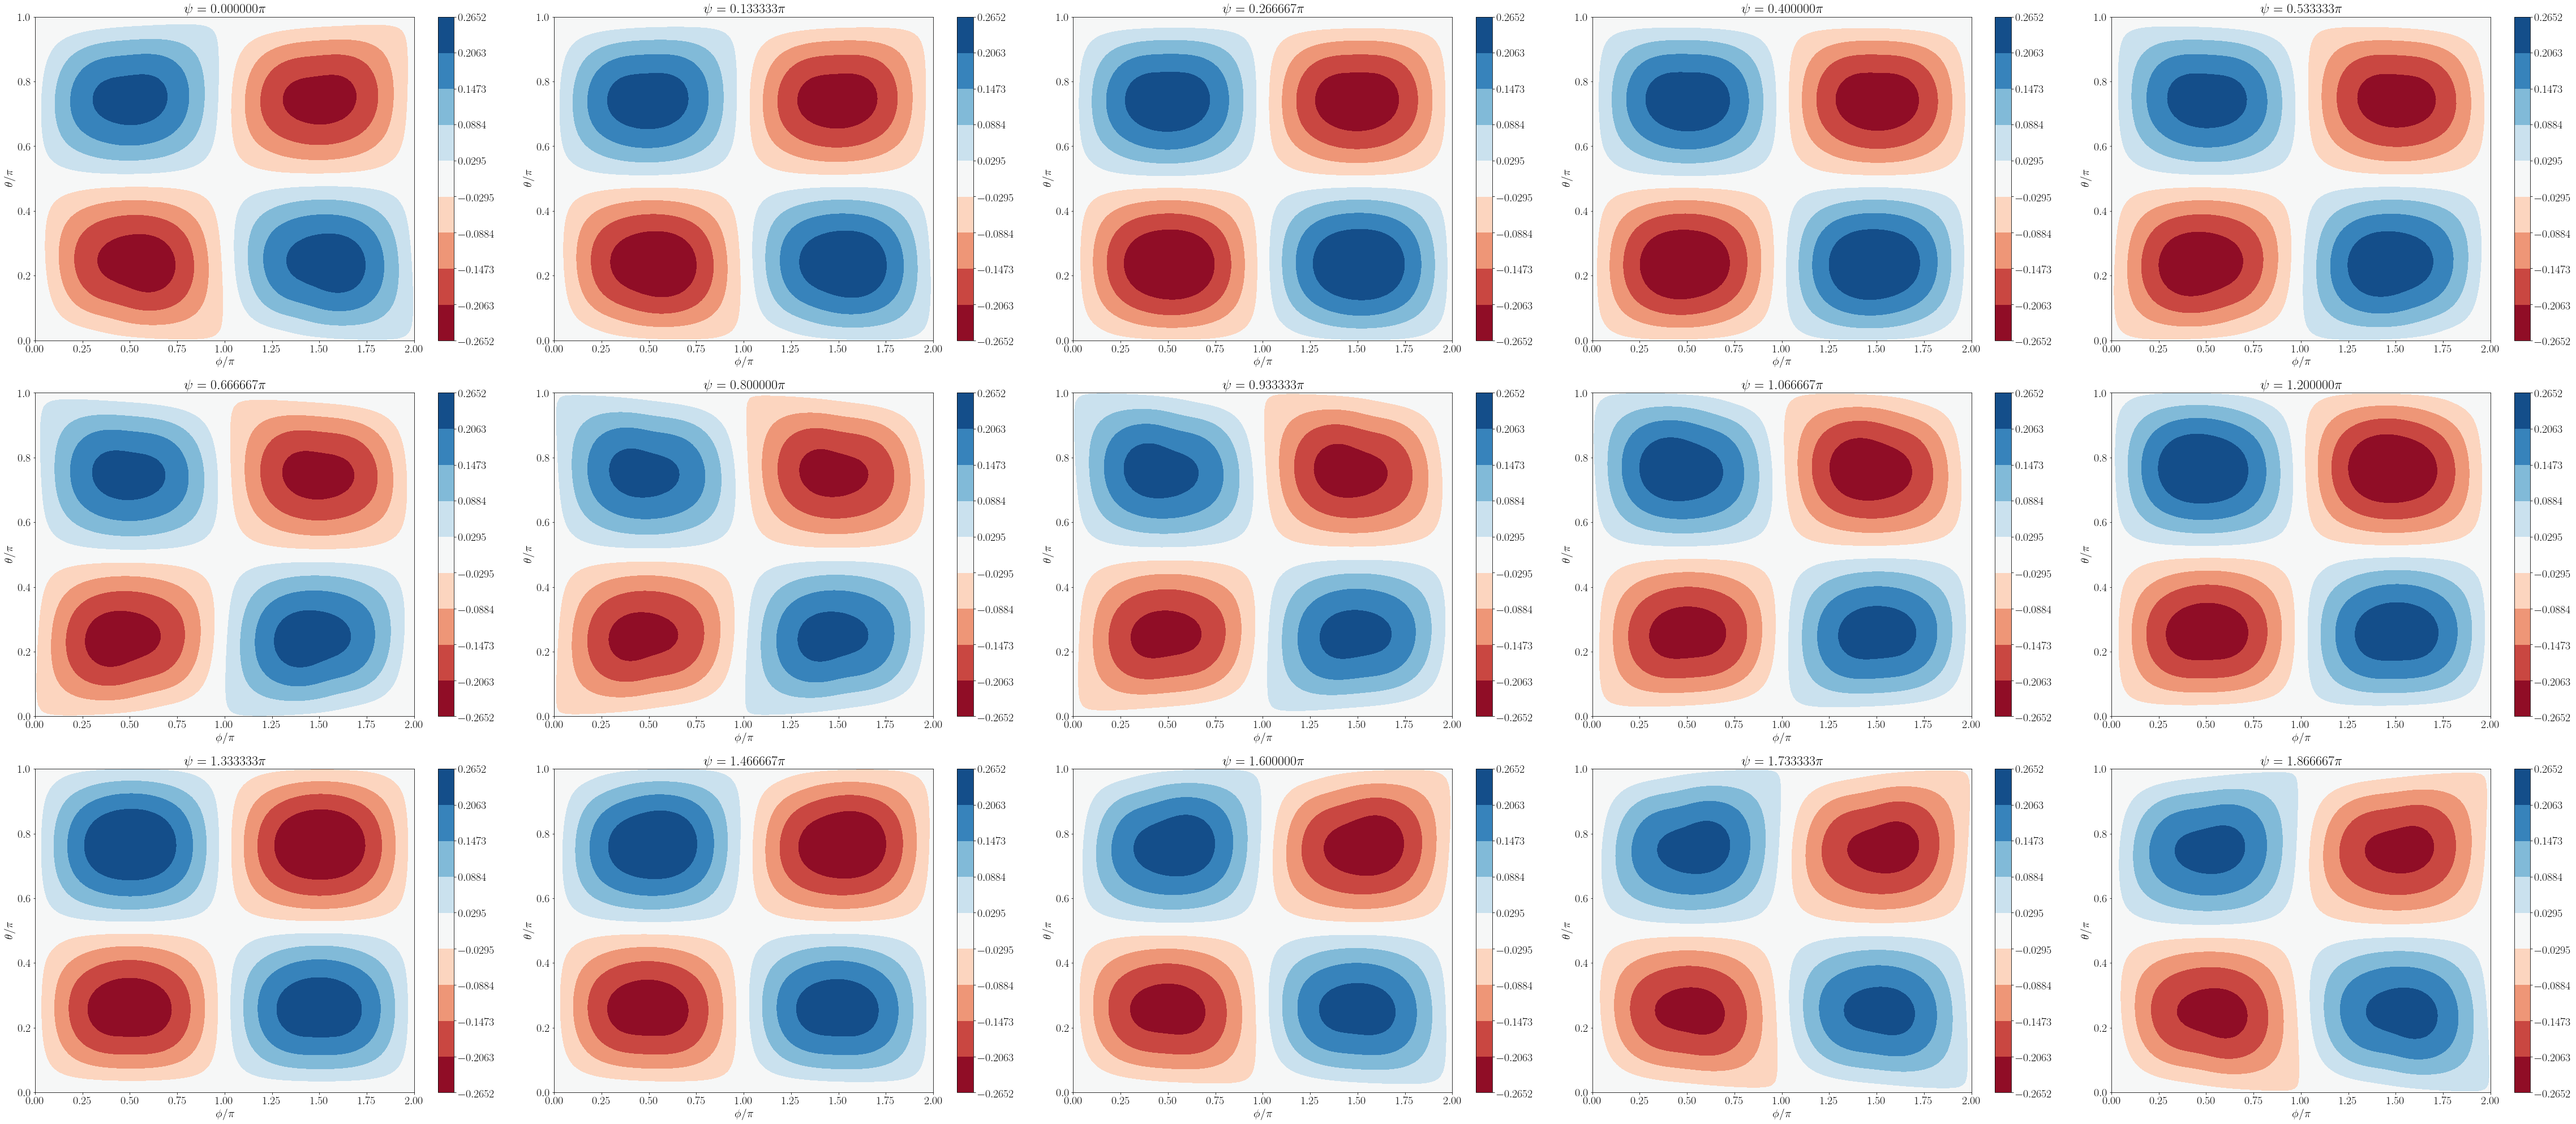

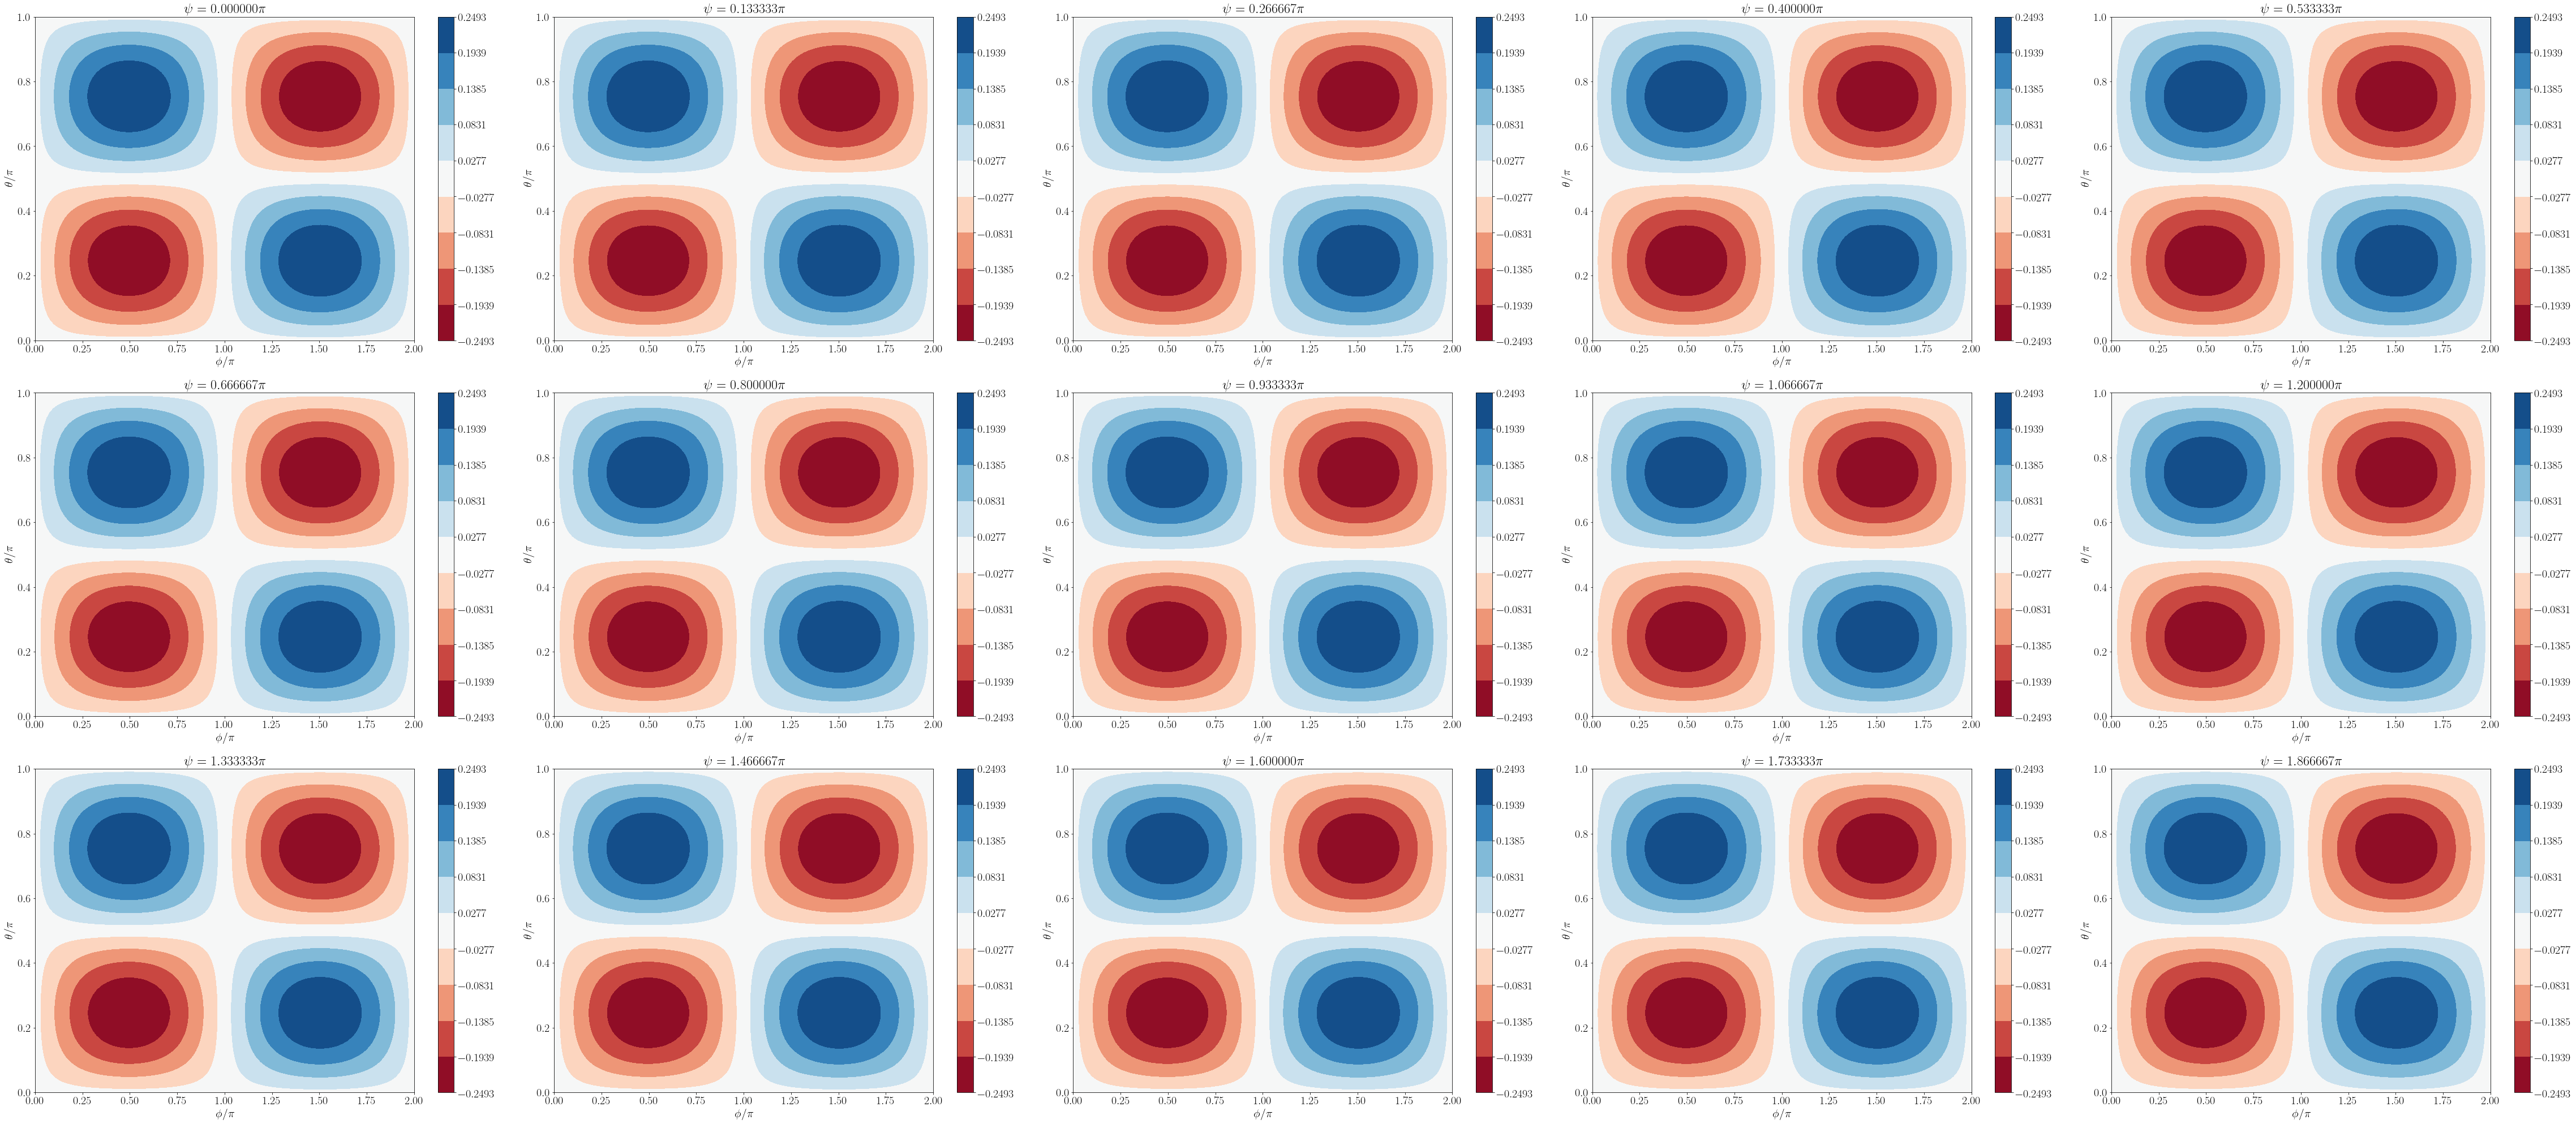

In [103]:
importlib.reload(spf_tb)

# ((psi, ((theta, phi, ui), )))
with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta_all, tphi_all = pickle_data[0][1][0][:2]
tpsi_all = np.array([ti[0] for ti in pickle_data])
U_all = [[] for i in range(6)]
for _, table_psi_data in pickle_data:
    for (_, _, tU), Ui in zip(table_psi_data, U_all):
        Ui.append(tU)
tw = np.dstack(U_all[use_uidx])

spf_tb.show_3dfft_major(tw, tktltj_list, ttheta_all, tphi_all, tpsi_all)

## obtain gijk (hijk) from ux, uy, and uz (wx, wy, and wz)

In [47]:
importlib.reload(spf_tb)
fft_pickle = 'hlxB01_tau1a'

with open('%s.pickle' % fft_pickle, 'rb') as handle:
    pickle_data = pickle.load(handle)
ttheta_all, tphi_all = pickle_data[0][1][0][:2]
tpsi_all = np.array([ti[0] for ti in pickle_data])
U_all = [[] for i in range(6)]
for _, table_psi_data in pickle_data:
    for (ttheta, tphi, tU), Ui in zip(table_psi_data, U_all):
        Ui.append(tU)

In [20]:
from shutil import copyfile

pickle_name = 'hlxB01_baseFlow2'
mdf_pickle_name = 'hlxB01_baseFlow2_mdf'

with open('%s.pickle' % pickle_name, 'rb') as handle:
    pickle_dict = pickle.load(handle)

t1 = pickle_dict['uw_Base_list'].copy()
for i0 in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    t1[i0] = np.zeros_like(t1[i0])
# usym = (pickle_dict['uw_Base_list'][4][1] + pickle_dict['uw_Base_list'][5][0]) * 0.5
# wsym = (pickle_dict['uw_Base_list'][4][4] + pickle_dict['uw_Base_list'][5][3]) * 0.5 * 1
# uasm = (pickle_dict['uw_Base_list'][4][1] - pickle_dict['uw_Base_list'][5][0]) * 0.5
# wasm = (pickle_dict['uw_Base_list'][4][4] - pickle_dict['uw_Base_list'][5][3]) * 0.5
# t1[4][1] = usym * 1 + uasm * 1 
# t1[4][4] = wsym * 1 + wasm * 1 
# t1[5][0] = usym * 1 - uasm * 1 
# t1[5][3] = wsym * 1 - wasm * 1 
# t1[4][2] = pickle_dict['uw_Base_list'][4][2] * 1
# t1[4][5] = pickle_dict['uw_Base_list'][4][5] * 1
# t1[9] = pickle_dict['uw_Base_list'][9]

usym = (pickle_dict['uw_Base_list'][4][1] + pickle_dict['uw_Base_list'][5][0]) * 0.5
wsym = 0
uasm = (pickle_dict['uw_Base_list'][4][1] - pickle_dict['uw_Base_list'][5][0]) * -0.5
wasm = 1
t1[4][1] = usym * 0 + uasm * 1 
t1[4][4] = wsym * 1 + wasm * 1 
t1[5][0] = usym * 0 - uasm * 1 
t1[5][3] = wsym * 1 - wasm * 1 
t1[2][0] = pickle_dict['uw_Base_list'][2][0] * -1
t1[9] = pickle_dict['uw_Base_list'][9]

with np.printoptions(linewidth=np.inf):
    display(np.vstack(t1)[1:6, :3])
    display(np.vstack(t1)[1:6, 3:])
    display(np.vstack(pickle_dict['uw_Base_list'])[1:6, :])

pickle_dict['uw_Base_list'] = t1
tname = '%s.pickle' % mdf_pickle_name
with open(tname, 'wb') as handle:
    pickle.dump(pickle_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
copyfile(tname, os.path.join(os.getcwd(), os.pardir, os.pardir, 'src', tname))
print('save table_data to %s' % tname)


array([[ 0.        ,  0.        ,  0.        ],
       [-0.02877624,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.02362168,  0.        ],
       [-0.02362168,  0.        ,  0.        ]])

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.]])

array([[-7.76050438e-03, -1.43094616e-06, -8.98056985e-07,  2.90110535e-02,  4.60651885e-07,  5.53857545e-06],
       [ 2.87762392e-02, -1.56820033e-06, -1.72287324e-06,  5.45523171e-02, -1.18706269e-05,  4.57812987e-06],
       [ 1.38196861e-06, -7.00913690e-03, -2.58032812e-04,  2.71220806e-06,  3.21295502e-02,  5.49852679e-02],
       [ 5.21018969e-07, -2.42684551e-02, -1.47877910e-02, -3.48444094e-06,  9.56561008e-01, -5.74835574e-02],
       [ 2.29749079e-02,  4.16386119e-07,  2.71114985e-07, -9.68502945e-01, -1.06032403e-06,  2.37665557e-06]])

save table_data to hlxB01_baseFlow2_mdf.pickle


In [45]:
pickle_name = 'hlxB01_baseFlow'
# pickle_name = 'hlxB01_baseFlow2'

with open('%s.pickle' % pickle_name, 'rb') as handle:
    pickle_dict = pickle.load(handle)

# print(np.vstack(pickle_dict['uw_Base_list']).shape)
uEbase_list = np.vstack(pickle_dict['uw_Base_list'])[1:6, 0:3]
uSbase_list = np.vstack(pickle_dict['uw_Base_list'])[6:9, 0:3]
wEbase_list = np.vstack(pickle_dict['uw_Base_list'])[1:6, 3:6]
wSbase_list = np.vstack(pickle_dict['uw_Base_list'])[6:9, 3:6]
print(wEbase_list)
print(wSbase_list)
print(pickle_dict['uw_Base_list'][9])

[[ 2.88299473e-02 -1.46853323e-06 -1.03064360e-06]
 [ 5.42510802e-02 -2.22381634e-06 -8.76820219e-06]
 [ 1.00153773e-06  3.19268703e-02  5.91691688e-02]
 [ 6.59827138e-07  9.56943091e-01 -5.45242721e-02]
 [-9.68509888e-01 -5.96048419e-08  6.67837781e-07]]
[[ 9.99991141e-01  4.01427885e-08  1.81961652e-07]
 [-3.04317227e-08  9.99962159e-01 -1.42913590e-03]
 [ 2.41049660e-08 -1.00253599e-04  9.96619293e-01]]
[0. 0. 0. 0. 0. 0.]


In [50]:
importlib.reload(spf_tb)
pickle_name = 'hlxB01_baseFlow'

with open('%s.pickle' % pickle_name, 'rb') as handle:
    pickle_dict = pickle.load(handle)
uEbase_list = np.vstack(pickle_dict['uw_Base_list'])[1:6, 0:3]
uSbase_list = np.vstack(pickle_dict['uw_Base_list'])[6:9, 0:3]
wSbase_list = np.vstack(pickle_dict['uw_Base_list'])[6:9, 3:6]

wEbase_list0 = np.vstack(pickle_dict['uw_Base_list'])[1:6, 3:6]
wEbase_list = np.zeros_like(wEbase_list0)
wEbase_list[3, 1] = wEbase_list0[3, 1]
wEbase_list[4, 0] = wEbase_list0[4, 0]

U_cal_all = [[] for i in range(6)]
uS_cal_list = []
for i0 in range(tpsi_all.size):
    tpsi = tpsi_all[i0]
    tux = U_all[0][i0]
    tuy = U_all[1][i0]
    tuz = U_all[2][i0]
    tux_cal = tux.copy()
    tuy_cal = tuy.copy()
    tuz_cal = tuz.copy()
    for i1 in range(ttheta_all.size):
        ttheta = ttheta_all[i1]
        for i2 in range(tphi_all.size):
            tphi = tphi_all[i2]
            
            Eij_loc = spf_tb.Eij_loc(ttheta, tphi, tpsi)
            Sij_loc = spf_tb.Sij_loc(ttheta, tphi, tpsi)
            Ebase_fct = np.array([Eij_loc[0, 0], Eij_loc[2, 2], Eij_loc[0, 1], Eij_loc[0, 2], Eij_loc[1, 2]])
            Sbase_fct = np.array([Sij_loc[2, 1], Sij_loc[0, 2], Sij_loc[1, 0]])
            uE_loc = np.sum([a * b for a, b in zip(Ebase_fct, uEbase_list)], axis=0)
            uE = np.dot(spf_tb.Rloc2glb(ttheta, tphi, tpsi), uE_loc)
            uS = np.array((0, 0, 0))
            tu_cal = uE + uS
            tux_cal.iloc[i1].iloc[i2] = tu_cal[0]
            tuy_cal.iloc[i1].iloc[i2] = tu_cal[1]
            tuz_cal.iloc[i1].iloc[i2] = tu_cal[2]
    U_cal_all[0].append(tux_cal)
    U_cal_all[1].append(tuy_cal)
    U_cal_all[2].append(tuz_cal)
# print(np.linalg.norm(np.vstack(uS_cal_list) - np.array((0, 0, 0)), axis=-1).max())

wS_cal_list = []
wE_err_list = []
for i0 in range(tpsi_all.size):
    tpsi = tpsi_all[i0]
    twx = U_all[3][i0]
    twy = U_all[4][i0]
    twz = U_all[5][i0]
    twx_cal = twx.copy()
    twy_cal = twy.copy()
    twz_cal = twz.copy()
    for i1 in range(ttheta_all.size):
        ttheta = ttheta_all[i1]
        for i2 in range(tphi_all.size):
            tphi = tphi_all[i2]
            
            Eij_loc = spf_tb.Eij_loc(ttheta, tphi, tpsi)
            Sij_loc = spf_tb.Sij_loc(ttheta, tphi, tpsi)
            Ebase_fct = np.array([Eij_loc[0, 0], Eij_loc[2, 2], Eij_loc[0, 1], Eij_loc[0, 2], Eij_loc[1, 2]])
            Sbase_fct = np.array([Sij_loc[2, 1], Sij_loc[0, 2], Sij_loc[1, 0]])
            wE_loc = np.sum([a * b for a, b in zip(Ebase_fct, wEbase_list)], axis=0)
            wE = np.dot(spf_tb.Rloc2glb(ttheta, tphi, tpsi), wE_loc)
#             wS_loc = np.sum([a * b for a, b in zip(Sbase_fct, wSbase_list)], axis=0)
#             wS = np.dot(spf_tb.Rrot(ttheta, tphi, tpsi), wS_loc)
#             wS_cal_list.append(wS)
            wS = np.array((0, 0.5, 0))
            tw_cal = wE + wS
            twx_cal.iloc[i1].iloc[i2] = tw_cal[0]
            twy_cal.iloc[i1].iloc[i2] = tw_cal[1]
            twz_cal.iloc[i1].iloc[i2] = tw_cal[2]
    U_cal_all[3].append(twx_cal)
    U_cal_all[4].append(twy_cal)
    U_cal_all[5].append(twz_cal)
# print(np.linalg.norm(np.vstack(wS_cal_list) - np.array((0, 0.5, 0)), axis=-1).max())
# print(np.linalg.norm(np.vstack(wE_err_list), axis=-1).max())

In [58]:
for use_uidx in (0, 1, 2, 3, 4, 5):
    tu_cal = np.dstack(U_cal_all[use_uidx])
    spf_tb.core_show_ui_psi(tu_cal, ttheta_all, tphi_all, tpsi_all, dpi=200, polar=True)

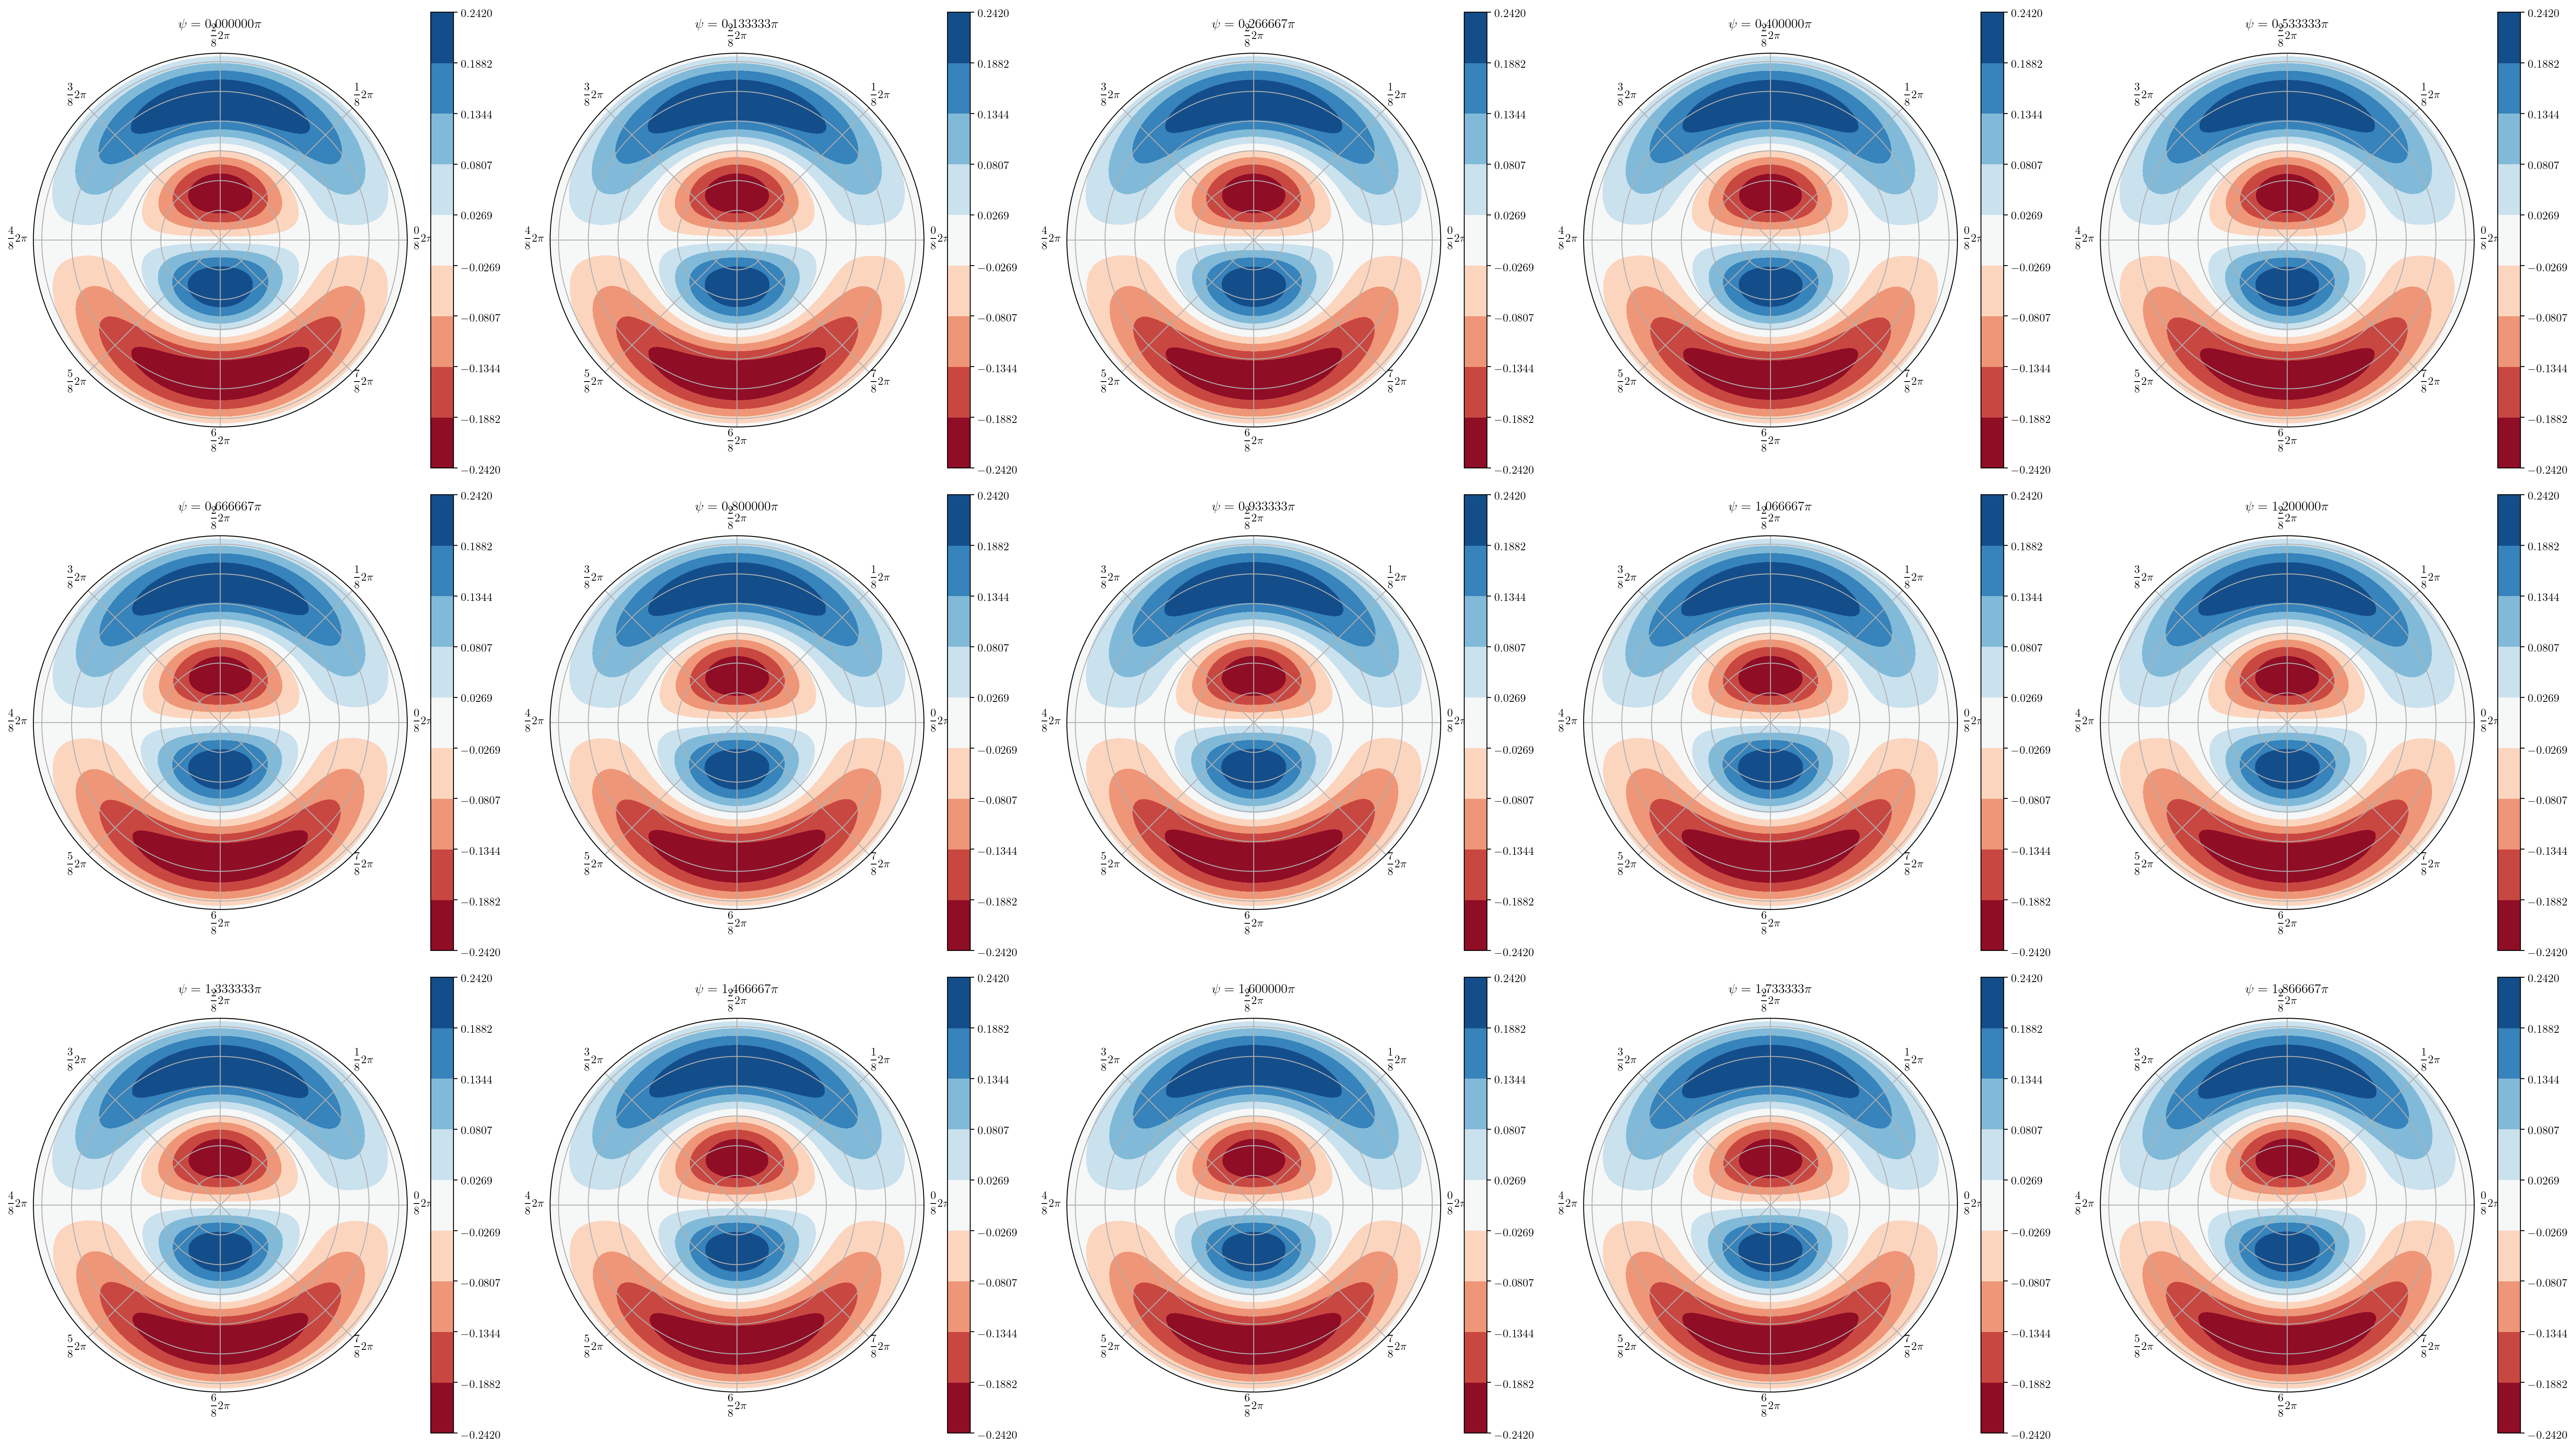

In [57]:
spf_tb.core_show_ui_psi(tu_cal, ttheta_all, tphi_all, tpsi_all, dpi=200, polar=True)

In [52]:
for use_uidx in (0, 1, 2, 3, 4, 5):
    tu_cal = np.dstack(U_cal_all[use_uidx])
    tu_sim = np.dstack(U_all[use_uidx])
    spf_tb.show_ui_psi(tu_cal - tu_sim, ttheta_all, tphi_all, tpsi_all, dpi=200)

In [29]:
from src.objComposite import *
from codeStore.helix_common import *
from src import stokes_flow as sf

problem_kwargs = {'nth': 10, 
                  'rh11': 0.1, 
                  'solve_method': 'gmres', 
                  'save_vtk': False, 
                  'plot_geo': False, 
                  'rot_theta': 0, 
                  'ffweighty': 2.0, 
                  'restart': False, 
                  'n_tail': 1, 
                  'getConvergenceHistory': False, 
                  'center': np.array([0, 0, 0]), 
                  'ffweightT': 2.0, 
                  'eh': -1.0, 
                  'precondition_method': 'none', 
                  'region_type': 'rectangle', 
                  'belemshandle': 'belems', 
                  'matname': 'body1', 
                  'field_range': np.array([[-3, -3, -3], [ 3,  3,  3]]), 
                  'hfct': 1.0, 
                  'rel_Uh': np.array([0., 0., 0., 0., 0., 0.]), 
                  'ffweightz': 2.0, 
                  'matrix_method': 'pf', 
                  'ph': 0.666667, 
                  'n_node_threshold': 5000, 
                  'zoom_factor': 1.0, 
                  'left_hand': False, 
                  'ch': 3.0, 
                  'ffweightx': 2.0, 
                  'fileHandle': 'hlxC01B05_baseFlow',
                  'rh1': 0.2, 'with_cover': 2,
                  'rT2': 0.001, 
                  'rot_norm': np.array([1, 0, 0]), 
                  'rh2': 0.03, 
                  'repeat_n': 1, 
                  'n_grid': np.array([10, 10, 10]), 
                  'bnodeshandle': 'bnodes', 
                  'basei': 1, 
                  'MPISIZE': 1, 
                  'rh12': 0.1, 
                  'pickProblem': False}

tail_obj_list = create_ecoli_tail(moveh=np.zeros(3), **problem_kwargs)



<IPython.core.display.Javascript object>


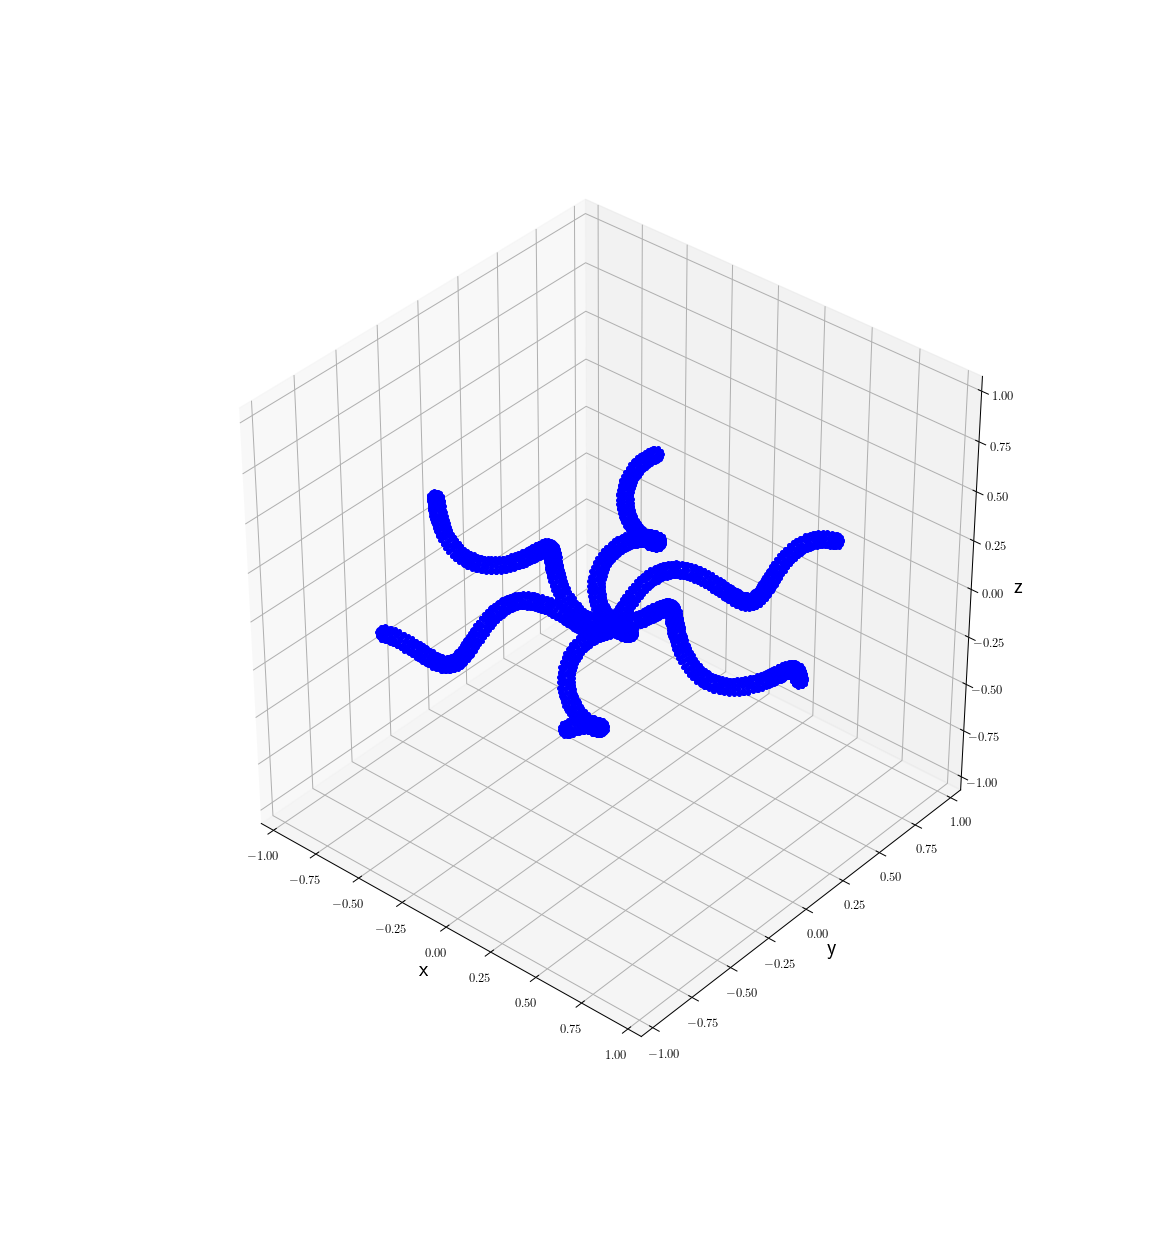

True

In [44]:
%matplotlib notebook

tail_obj_list = create_ecoli_tail(moveh=np.zeros(3), **problem_kwargs)
tobj = sf.StokesFlowObj()
tobj.combine(tail_obj_list)
tobj.node_rotation(norm=np.array([0, 1, 0]), theta=np.pi / 2)
tobj2 = tobj.copy()
tobj.node_rotation(norm=np.array([0, 0, 1]), theta=np.pi / 3)
tobj3 = tobj.copy()
tobj3.node_rotation(norm=np.array([0, 0, 1]), theta=np.pi / 3 * 4)


tobj_all = sf.StokesFlowObj()
tobj.combine((tobj, tobj2, tobj3))
tobj.show_u_nodes(linestyle='')
